# Anomaly Detection in Keras

- [Source](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_14_03_anomaly.ipynb)
    - Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
    - For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).
    
## What Are Anomalies?
데이터 마이닝에서 이상 징후 검출(내지는 이상치 검출)은 데이터와 현저하게 다른 것으로 의심되는 항목, 사건을 식별하는 것입니다. 이상 징후는 크게 다음과 같이 분류할 수 있습니다.

Point Anomalies(포인트 이상 징후): 데이터의 단일 인스턴스가 나머지 데이터와 너무 멀리 떨어져 있는 경우입니다. 비즈니스 사례로는 "지불된 금액"을 기준으로 신용 카드 사기 감지가 존재합니다.

Contextual Anomalies(상황별 이상 징후): 이상은 상황에 따라 다릅니다. 이 유형의 Anomaly Values는 시계열 데이터에서 흔히 볼 수 있습니다. 비즈니스 활용 사례로는 연휴 기간 동안 매일 음식에 100달러를 쓰는 것은 정상이지만 그렇지 않으면 이상할 수 있다는 것입니다.

Collective Anomalies(집단 이상 징후): 일련의 데이터 인스턴스는 모두 이상 징후를 탐지하는 데 도움이 됩니다. 개별 데이터 인스턴스는 그 자체로 이상이 아닐 수 있지만 집단으로서 함께 발생하는 것을 집단 이상이라고 말합니다. 

## Import Module

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import get_file

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.display import display, HTML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

C:\Users\PARK\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\PARK\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\PARK\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\PARK\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [2]:
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 

C:\Users\PARK\.keras\datasets\kddcup.data_10_percent.gz


## Load Data

<img src="https://hackernoon.com/hn-images/1*TYAzzTJ60x-qg5N81ElU9A.png" width="600">

### Description

네트워크 침입을 탐지하는 소프트웨어는 기업 내부자를 포함하여 무단 사용자로부터 컴퓨터 네트워크를 보호합니다. 침입 탐지기 학습 과제는 침입 또는 공격(Attack.)이라고 하는 "나쁜" 연결과 좋은 "정상적인 연결"을 구분할 수 있는 예측 모델을 구축하는 것이 목표였습니다. 

1998 DAPRA 침입 탐지 평가 프로그램은 MIT Lincoln Labs에서 총괄했습니다. 목적은 무단 네트워크 침입 연구를 조사하고 평가하는 것입니다. 군 네트워크 환경에서 시뮬레이션을 수행한 다양한 침입 유형을 포함한 데이터 셋이 이번 분석 데이터입니다.

원 자료는 7 주간의 네트워크 트패픽에서 약 4GB의 압축 바이너리 TCP(Transmission Control Protocol, 전송 제어 프로토콜) 덤프 데이터입니다. 약 5 백만 개의 레코드로 구성되어 있습니다. 또한, 2 주간의 테스트 데이터는 약 2 백만 개의 레코드로 구성되어 있습니다. 우리는 전체 데이터의 10% 샘플링 데이터를 사용하여 이번 커널을 수행할 것입니다.

각 행은 하나의 Connection으로 구성 되어있으며, Connection(연결)이란 정상적으로 정의된 시간에 시작하고 끝나는 일련의 TCP 패킷입니다. 또한, 각 연결에는 정확히 하나의 특정 공격 유형이 존재하는 Normal.(정상) 및 공격으로 라벨링 되어 있습니다.

이 데이터에서 가장 중요한 것은 훈련 데이터와 테스트 데이터의 분포 차이입니다. 테스트 데이터는 <b> 훈련 데이터와 동일한 확률 분포가 아니며, 훈련 데이터에 없는 특정 공격 유형을 포함한다는 점에 유의</b>해야합니다. 

In [75]:
df = pd.read_csv(path, header = None)

print("Read {} rows.".format(len(df)))

df.dropna(inplace = True, axis = 1)

df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

df.head()

Read 494021 rows.


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [76]:
raw_df = df.copy()

## Define Function

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

## Exploratory Data Analysis

### Check Missing Value & Unique Value

In [5]:
resumetable(df)

Dataset Shape: (494021, 42)


,Name,dtypes,Missing,Uniques
0,duration,int64,0,2495
1,protocol_type,object,0,3
2,service,object,0,66
3,flag,object,0,11
4,src_bytes,int64,0,3300
5,dst_bytes,int64,0,10725
6,land,int64,0,2
7,wrong_fragment,int64,0,3
8,urgent,int64,0,4
9,hot,int64,0,22


데이터는 494,021개의 관측값과 42개의 컬럼으로 구성되어 있다는 것을 확인할 수 있습니다. 또한, 결측값은 존재하지 않고 고유값들은 관측값 수에 비해 그 수가 적다는 것을 알 수 있습니다.

42개의 피쳐에 대한 설명은 다음과 같습니다. 먼저 연속형 변수에 대한 설명입니다.

- duration: 연결 시간(초)
- src_bytes: 소스IP에서 대상IP까지 전송된 데이터 바이트 수
- dst_bytes: 대상IP에서 소스IP까지 전송된 데이터 바이트 수
- wrong_fragment: "wrong" 조각의 수 (?)
- urgent: 긴급 패킷 수
- hot: "hot" 표시기 수 (?)
- num_failed_logins: 실패한 로그인 시도 횟수
- num_compromised: 손상된 조건의 수(?)
- num_root: Root 접근 횟수
- num_file_creations: 파일 생성 작업 횟수
- num_shells: Shell 프롬프트 수
- num_access_files: 접근 제어 파일의 작동 횟수
- num_outbound_cmds: FTP 세션의 아웃바운드 수
- count: 지난 2초 동안 현재 연결과 동일한 호스트에 대한 연결 수

Note: 다음 피쳐는 동일한 호스트 연결에 관련된 피쳐입니다.

- serror_rate: 'SYN' 에러가 발생한 연결 비율 (SYN: 연결 패킷 전송 오류)
- rerror_rate: 'REJ' 에러가 발생한 연결 비율 (REJ: 연결 시도 거부)
- same_srv_rate: 동일한 서비스에 대한 연결 비율
- diff_srv_rate: 다른 서비스에 대한 연결 비율

Note: 다음 피쳐는 동일한 서비스 연결에 관련된 피쳐입니다.

- srv_count: 지난 2초 동안 현재 연결과 동일한 서비스에 대한 연결 수
- srv_serror: 'SYN' 에러가 발생한 연결 비율
- srv_rerror_rate: 'REJ' 에러가 발생한 연결 비율 (REJ: 연결 시도 거부)
- srv_diff_host_rate: 다른 호스트에 대한 연결 비율

이제, 이산형 변수에 대한 설명입니다.

- protocol_type: 프로토콜 유형
- service: 대상IP의 네트워크 서비스
- flag: 연결의 정상 또는 오류 상태
- land: 연결이 동일한 호스트 및 포트에서 연결되는 경우. 1 = Y, 0 = N
- logged_in: 로그인 성공 여부 1 = Y, 0 = N
- root_shell: "Root Shell"이 확보 여부 1 = Y, 0 = N
- su_attempted: "su root" 명령 시도 여부 (sudo 등) 1 = Y, 0 = N
- is_hot_login: 로그인이 'hot'에 속하는 지에 대한 여부 1 = Y, 0 = N
- is_guest_login: guest 로그인 여부 1 = Y, 0 = N

### Summary Statistics

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,494021.0,47.979302,707.746472,0.0,0.00,0.0,0.00,58329.0
src_bytes,494021.0,3025.610296,988218.101045,0.0,45.00,520.0,1032.00,693375640.0
dst_bytes,494021.0,868.532425,33040.001252,0.0,0.00,0.0,0.00,5155468.0
land,494021.0,0.000045,0.006673,0.0,0.00,0.0,0.00,1.0
wrong_fragment,494021.0,0.006433,0.134805,0.0,0.00,0.0,0.00,3.0
urgent,494021.0,0.000014,0.005510,0.0,0.00,0.0,0.00,3.0
hot,494021.0,0.034519,0.782103,0.0,0.00,0.0,0.00,30.0
num_failed_logins,494021.0,0.000152,0.015520,0.0,0.00,0.0,0.00,5.0
logged_in,494021.0,0.148247,0.355345,0.0,0.00,0.0,0.00,1.0
num_compromised,494021.0,0.010212,1.798326,0.0,0.00,0.0,0.00,884.0


### Label
데이터의 라벨인 outcome의 라벨은 총 24개 가지의 공격 유형이 포함되어 있습니다. 

공격은 크게 4 가지 범주로 분류됩니다.
- DOS(Denial-Of-Service Attack): 서비스 거부 공격
- R2L: 원격 컴퓨터에서 무단 액세스
- U2R: 로컬 관리자 계정 권한에 대한 무단 액세스
- probing: 감시 및 기타 프로빙 (예: port scan)

제공된 데이터 설명에 명시되어있는 라벨 정보입니다. 공격 유형에 대한 정보는 [여기](http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types)에서 확인할 수 있습니다.

DOS 범주의 공격 유형은 다음과 같습니다. 
- back.
- land.
- neptune.
- smurf.
- teardrop.

R2L 범주의 공격 유형은 다음과 같습니다.
- ftp_write.
- guess_passwd.
- imap.
- multihop.
- phf.
- spy.
- warezclient.
- warezmaster.

U2R 범주의 공격 유형은 다음과 같습니다.
- buffer_overflow.
- loadmodule.
- perl.
- rootkit.

Probing 범주의 공격 유형은 다음과 같습니다.
- ipsweep.
- nmap.
- satan.

In [7]:
def AttackType(x):
    if x in ['back.', 'land.', 'neptune.', 'smurf.', 'teardrop.']:
        return 'DOS'
    
    elif x in ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'phf.', 'spy.', 'warezclient.', 'warezmaster.']:
        return 'R2L'
    
    elif x in ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.']:
        return 'U2R'
    
    elif x in ['ipsweep.', 'nmap.', 'satan.']:
        return 'Probe'
    
    else:
        return 'Normal'

attacktype = np.vectorize(AttackType)

df['Type'] = attacktype(df['outcome'])

In [8]:
print("Network Attack Type :",df['outcome'].unique())

print("\n Network Attack Four Type :", df['Type'].unique())

Network Attack Type : ['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']

 Network Attack Four Type : ['Normal' 'U2R' 'DOS' 'R2L' 'Probe']


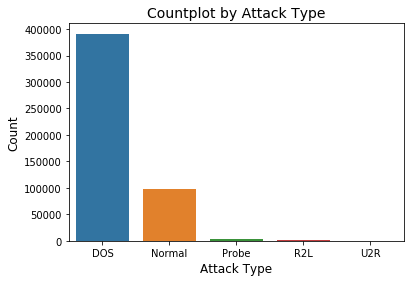

In [9]:
sns.countplot(df['Type'], order = df['Type'].value_counts().index)
plt.title('Countplot by Attack Type', fontsize = 14)
plt.xlabel('Attack Type', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

데이터의 라벨 빈도수 확인 결과, DOS 유형 공격이 가장 많다는 것을 알 수 있습니다.

필자는 네트워크 침입 탐지에 대한 도메인 지식이 부족한 상태입니다. 따라서 각 범주에 대한 설명을 확인한 후, 공격 유형의 특성을 확인할 것입니다. 

#### DOS(Deneial-Of-Service) Attack
시스템을 악의적으로 공격해 해당 시스템의 자원을 부족하게 하여 원래 의도된 용도로 사용하지 못하게 하는 공격 유형. 인터넷 사이트 또는 서비스의 기능을 일시적 또는 영구적으로 방해 및 중단을 초래한다. 통상적으로 은행, 신용카드 지불 게이트웨이, Root Name Server를 상대로 이루어진다.

- 특정 서버에게 수 많은 접속 시도를 생성해 다른 이용자가 정상적으로 서비스 이용을 하지 못하게 하는 특징
- 서버의 TCP 연결을 바닥내는 공격 유형
- 대표적으로 DDoS 공격.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Stachledraht_DDos_Attack.svg/1200px-Stachledraht_DDos_Attack.svg.png" width="350">

DOS 유형 공격의 증상은 다음과 같습니다.
- 비정상적인 네트워크 성능 저하
- 특정 또는 모든 웹사이트 접근 불가
- 특정 전자 우편의 급속한 증가

Source: https://ko.wikipedia.org/wiki/%EC%84%9C%EB%B9%84%EC%8A%A4_%EA%B1%B0%EB%B6%80_%EA%B3%B5%EA%B2%A9

In [10]:
df_dos = df.loc[df['Type'] == 'DOS']
df_normal = df.loc[df['Type'] == 'Normal']

In [38]:
cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login', 'outcome', 'Type']

def VisNumFeature(data, method = "hist", attack_type = None, scale = None):
    data = data.drop(columns = cat_cols)
    
    if method == "hist":
        
        f, axes = plt.subplots(5, 7, figsize = (25,30))
        for i, col in enumerate(data.columns):
 
            ax1 = sns.distplot(data[col], label = 'Attack', hist = False, ax = axes[i // 7][i % 7])
            ax1.set_title(col)
            global df_normal
            ax2 = sns.distplot(df_normal[col], label = 'Normal', hist = False, ax = axes[i//7][i%7])

            plt.legend([ax1,ax2],loc = 'best')

    elif method == "boxplot":
        if attack_type == None:
            raise AssertionError("attack_type must be defined.")
    
        f, axes = plt.subplots(5, 7, figsize = (25, 30))
        for i, col in enumerate(data.columns):
            
            global df
            df_type = df.loc[(df['Type'] == 'Normal') | (df['Type'] == attack_type)]
            
            ax = sns.boxplot(y = col, x = 'Type', data = df_type, ax = axes[i//7][i % 7])
            
            if scale == None:
                ax.set_title(col)
                ax.set_ylabel('Value')
                ax.set_xlabel('Type')
                
            elif scale == 'log':
                ax.set_yscale("log")
                ax.set_title(col)
                ax.set_ylabel('Log(Value)')
                ax.set_xlabel('Type')

def VisCatFeature(data, attack_type = None):
    data = data[cat_cols]
    data.drop(columns = ['outcome'], inplace = True)
    
    df_type = data.loc[(df['Type'] == 'Normal') | (df['Type'] == attack_type)]
    
    f, axes = plt.subplots(5, 2, figsize = (25,35))
    axes.flat[-1].set_visible(False)
    
    for i, col in enumerate(data.columns):
        
        ax = sns.countplot(x = col, hue = 'Type', data = df_type, order = df_type[col].value_counts().index, ax = axes[i // 2][i % 2])
        
        ax.set_title(col)
        ax.set_xlabel(" ")
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

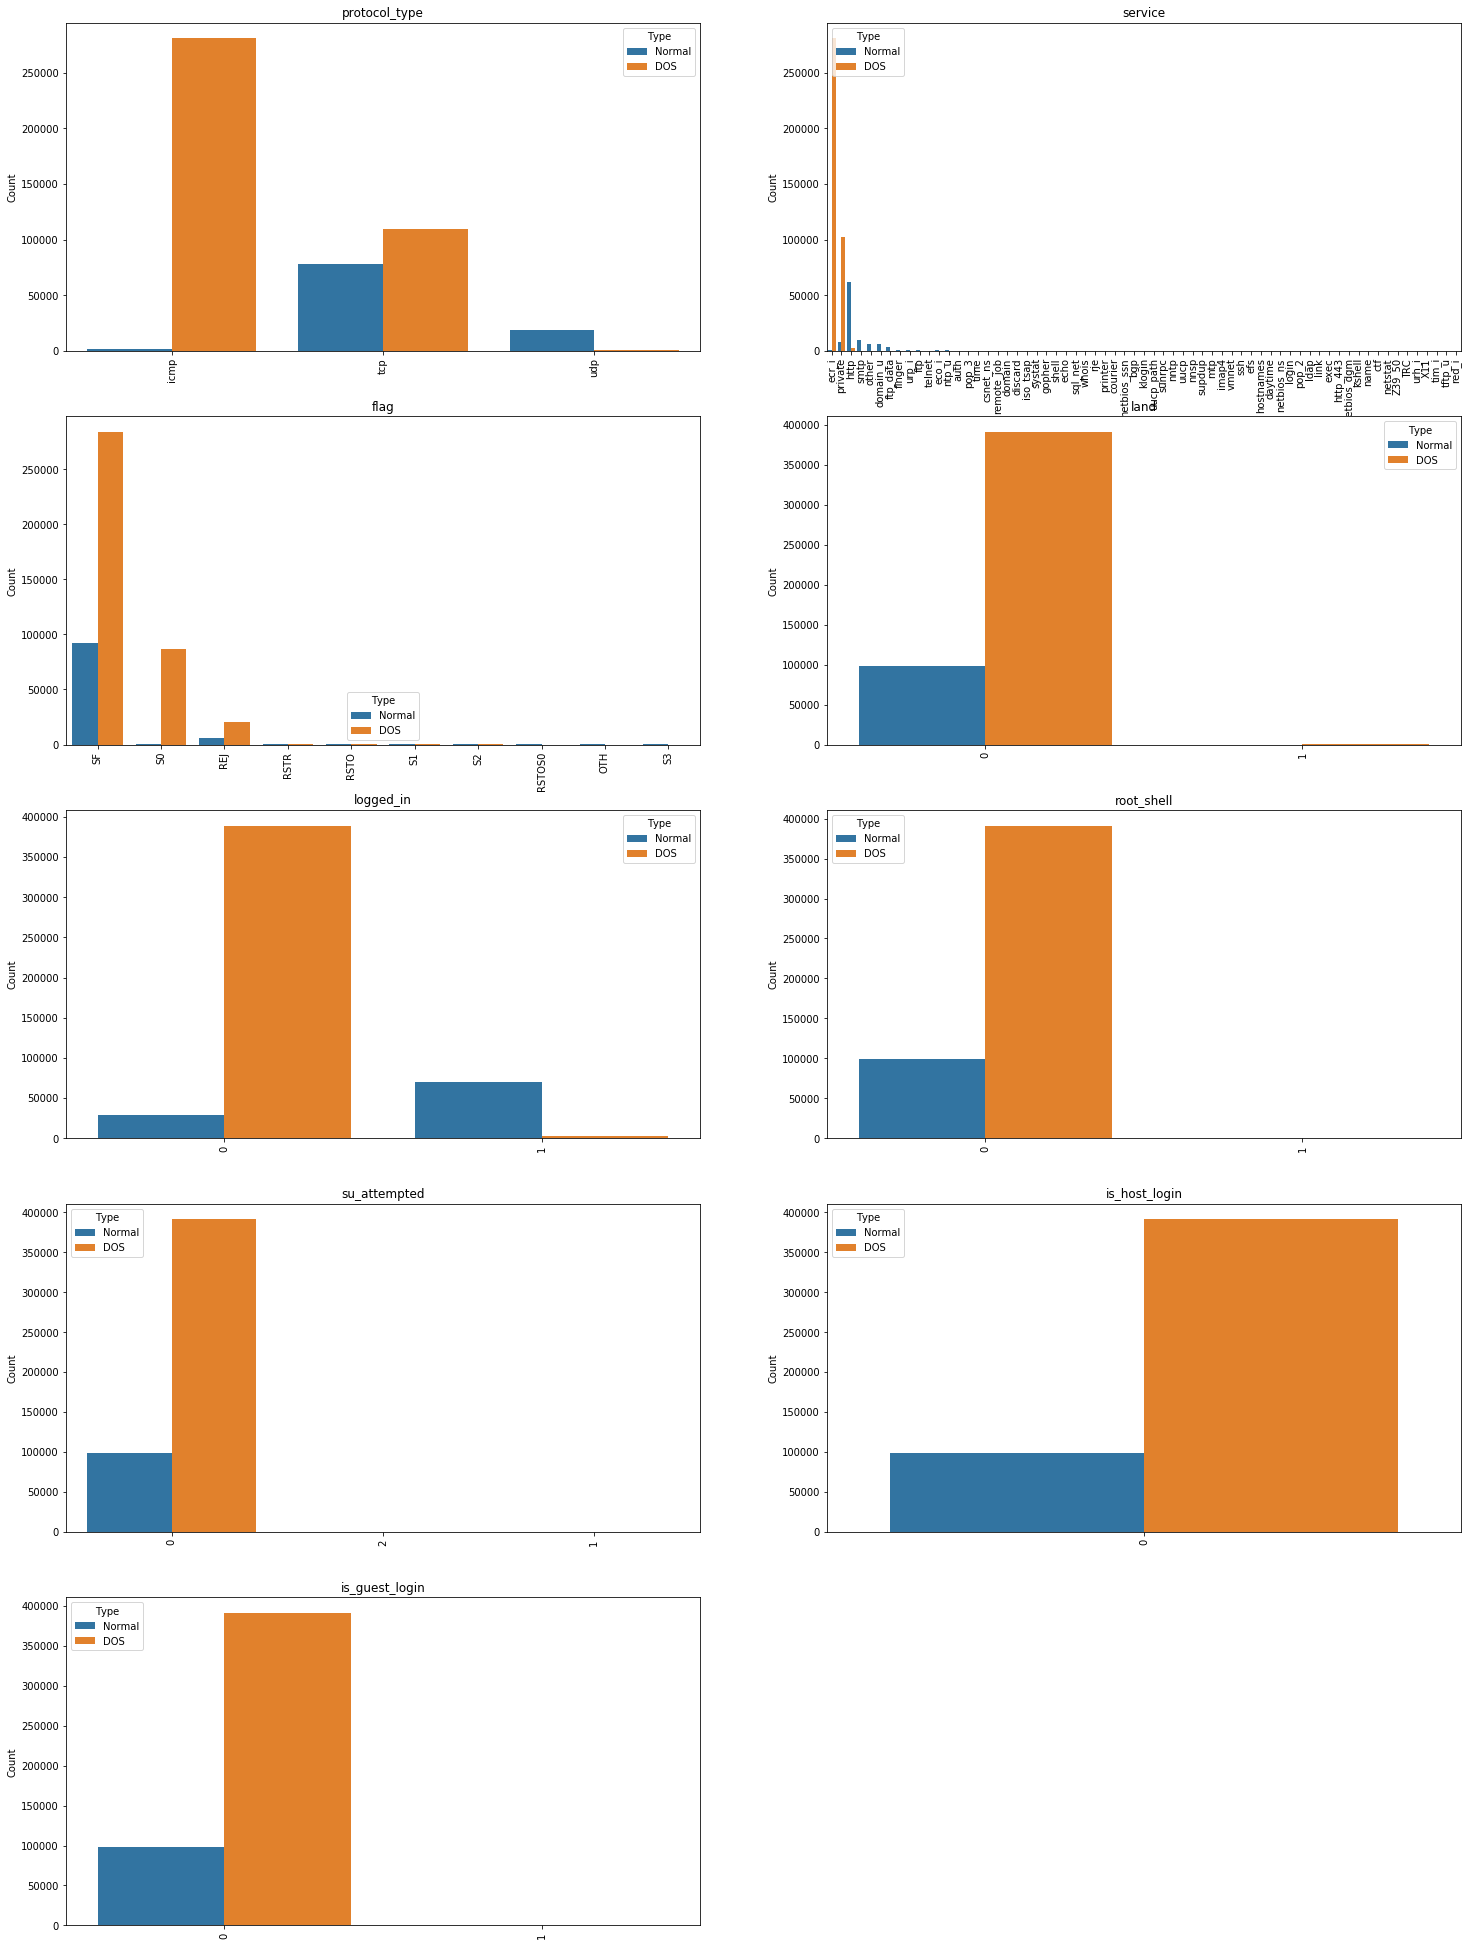

In [33]:
VisCatFeature(df, attack_type = 'DOS')

DOS 유형 공격의 특징은 다음과 같다.그래프를 해석할 때, 단순히 공격 연결 유형의 빈도수와 정상적인 연결의 빈도수를 비교하기에는 샘플의 수가 차이 나므로, 비율을 고려하여 특징을 확인한다.

- <b>icmp</b> 프로토콜을 이용하여 가장 많이 발생한다는 것을 알 수 있다. 정상적인 연결이 tcp와 udp를 통해 발생한다는 특징과 매우 대조적이다. 
- <b>ecr_i와 private</b>를 service로 공격이 많이 발생한다는 것을 알 수 있다. 정상적인 연결은 http를 통해 가장 많이 발생한다.
- 로그인 여부(logged_in)를 통해 공격은 대부분 로그인에 성공하지 못 했다는 것을 알 수 있다. 정상적인 연결은 상대적으로 로그인 성공 비율이 높다.

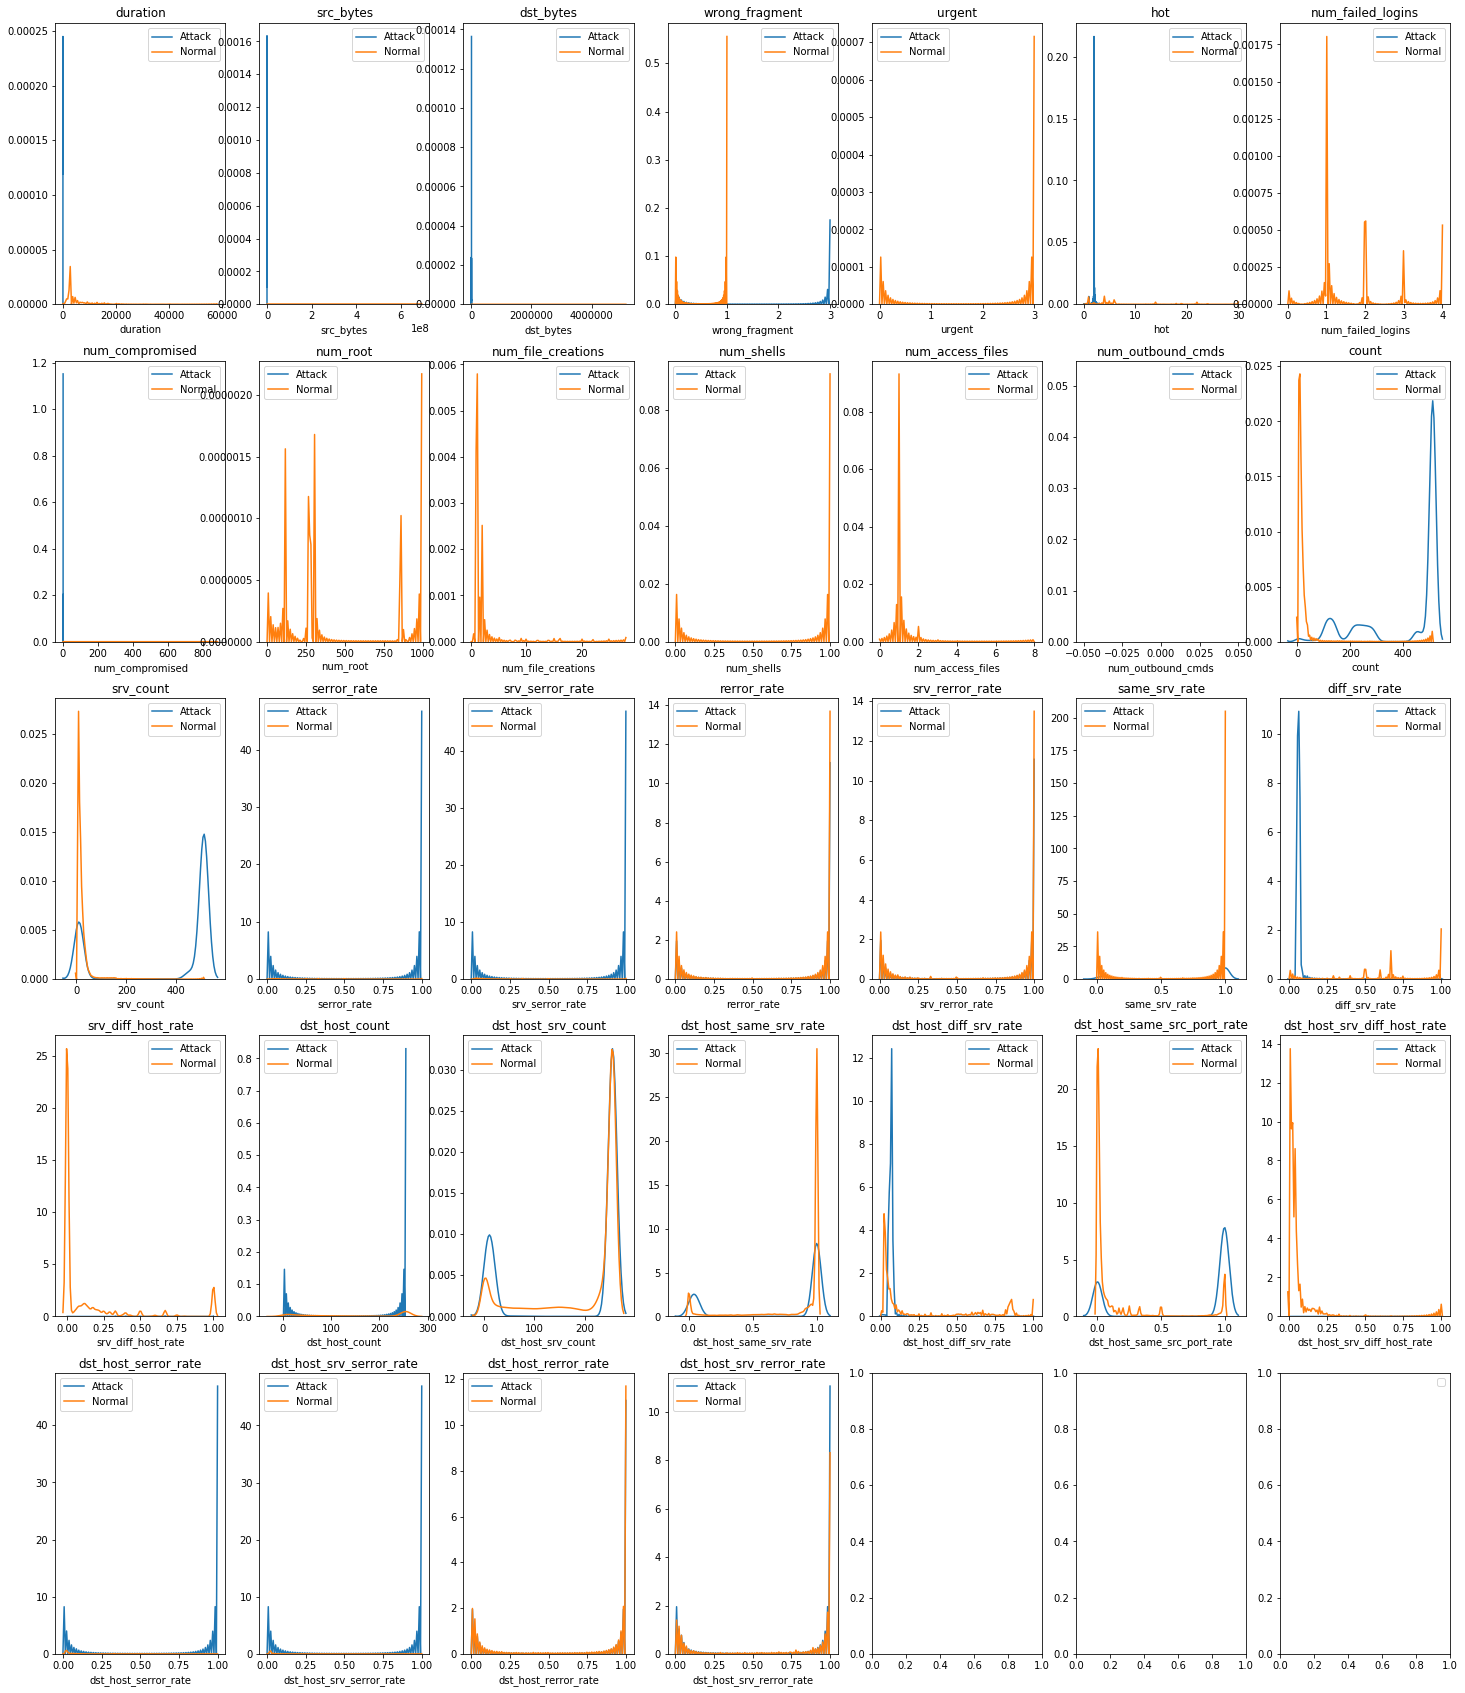

In [13]:
VisNumFeature(df_dos, method = 'hist')

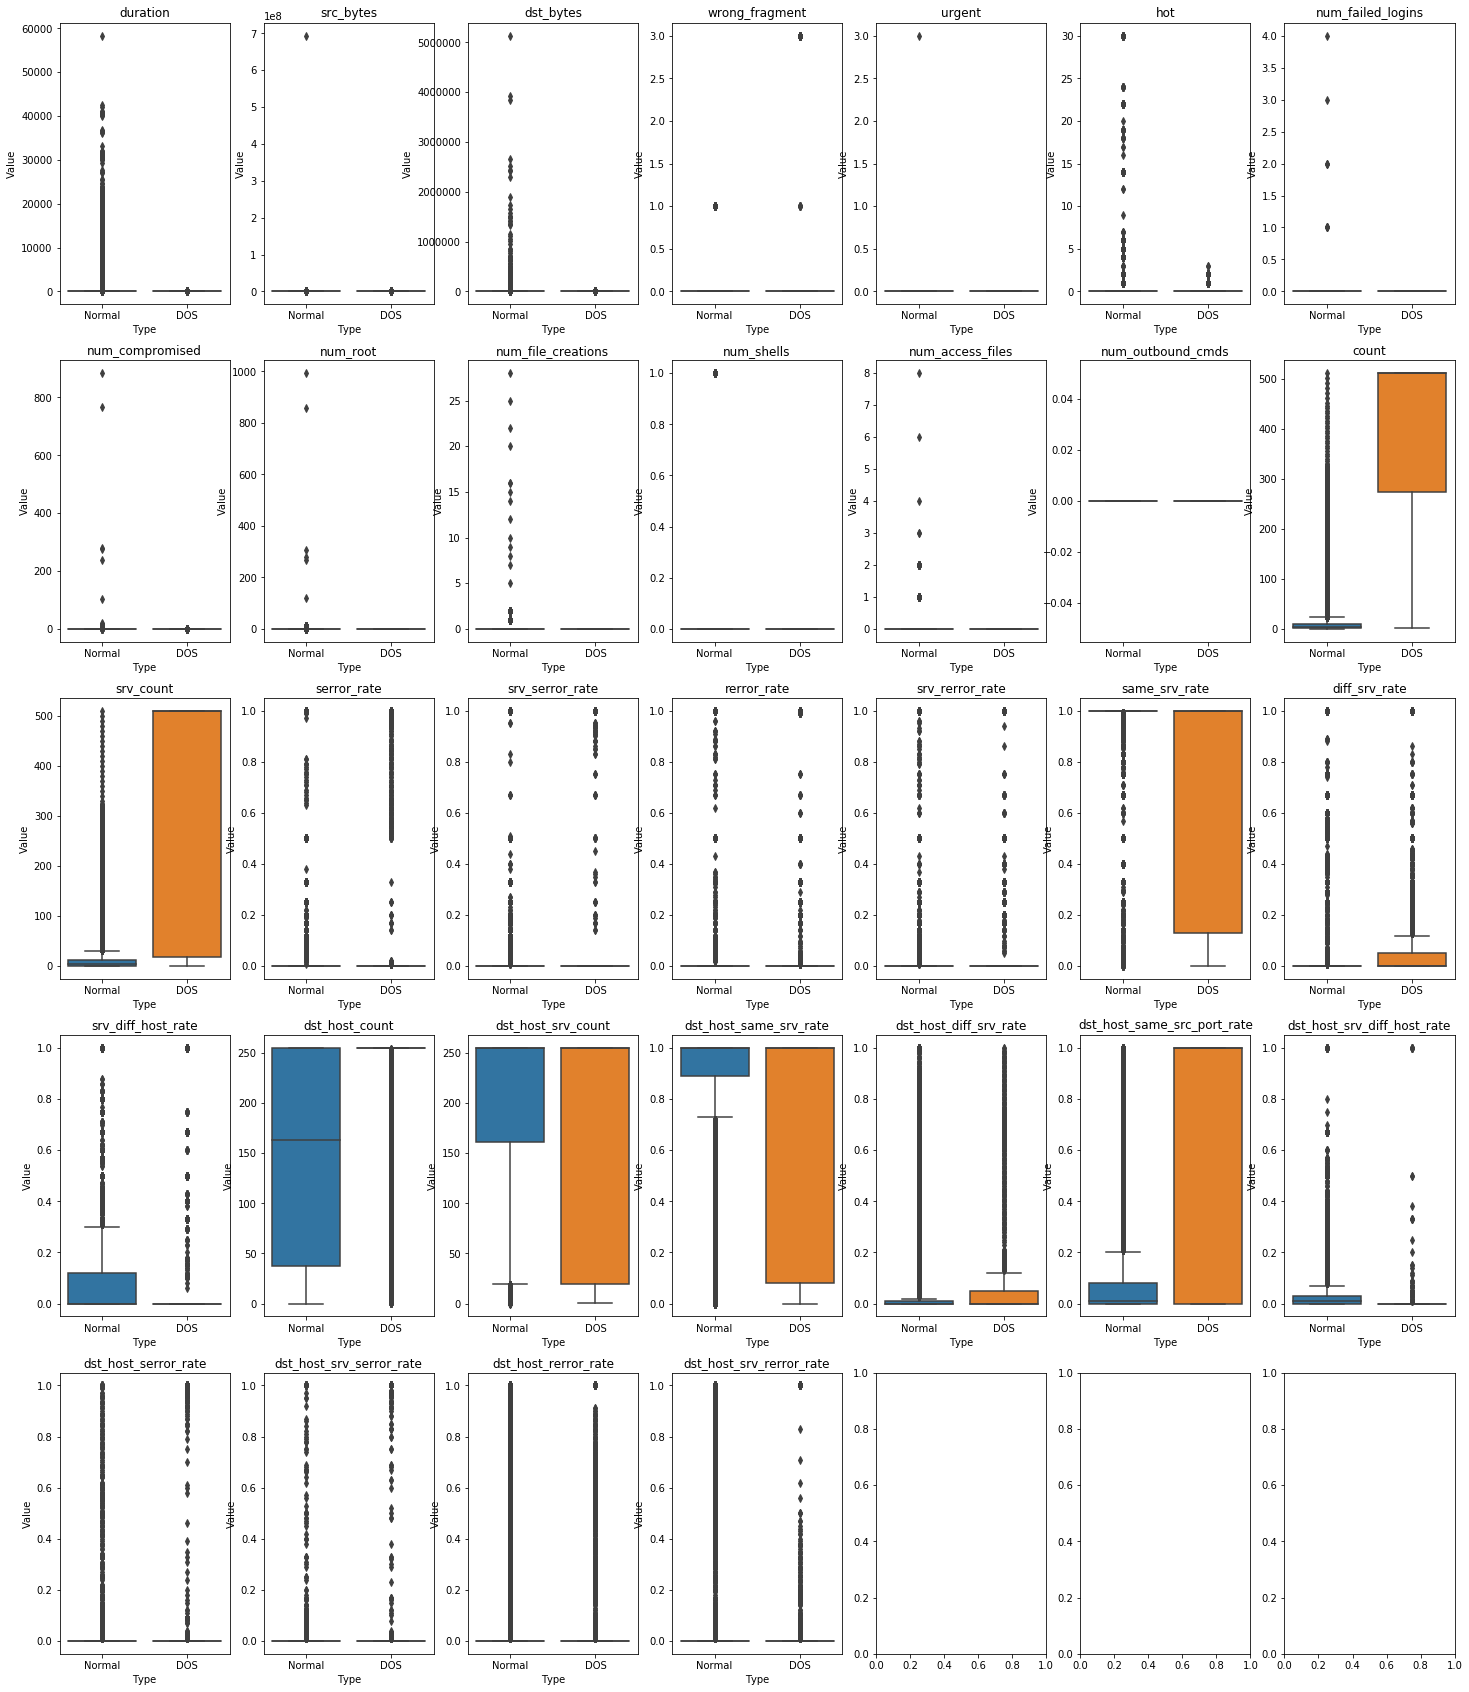

In [14]:
VisNumFeature(df_dos, method = 'boxplot', attack_type = 'DOS')

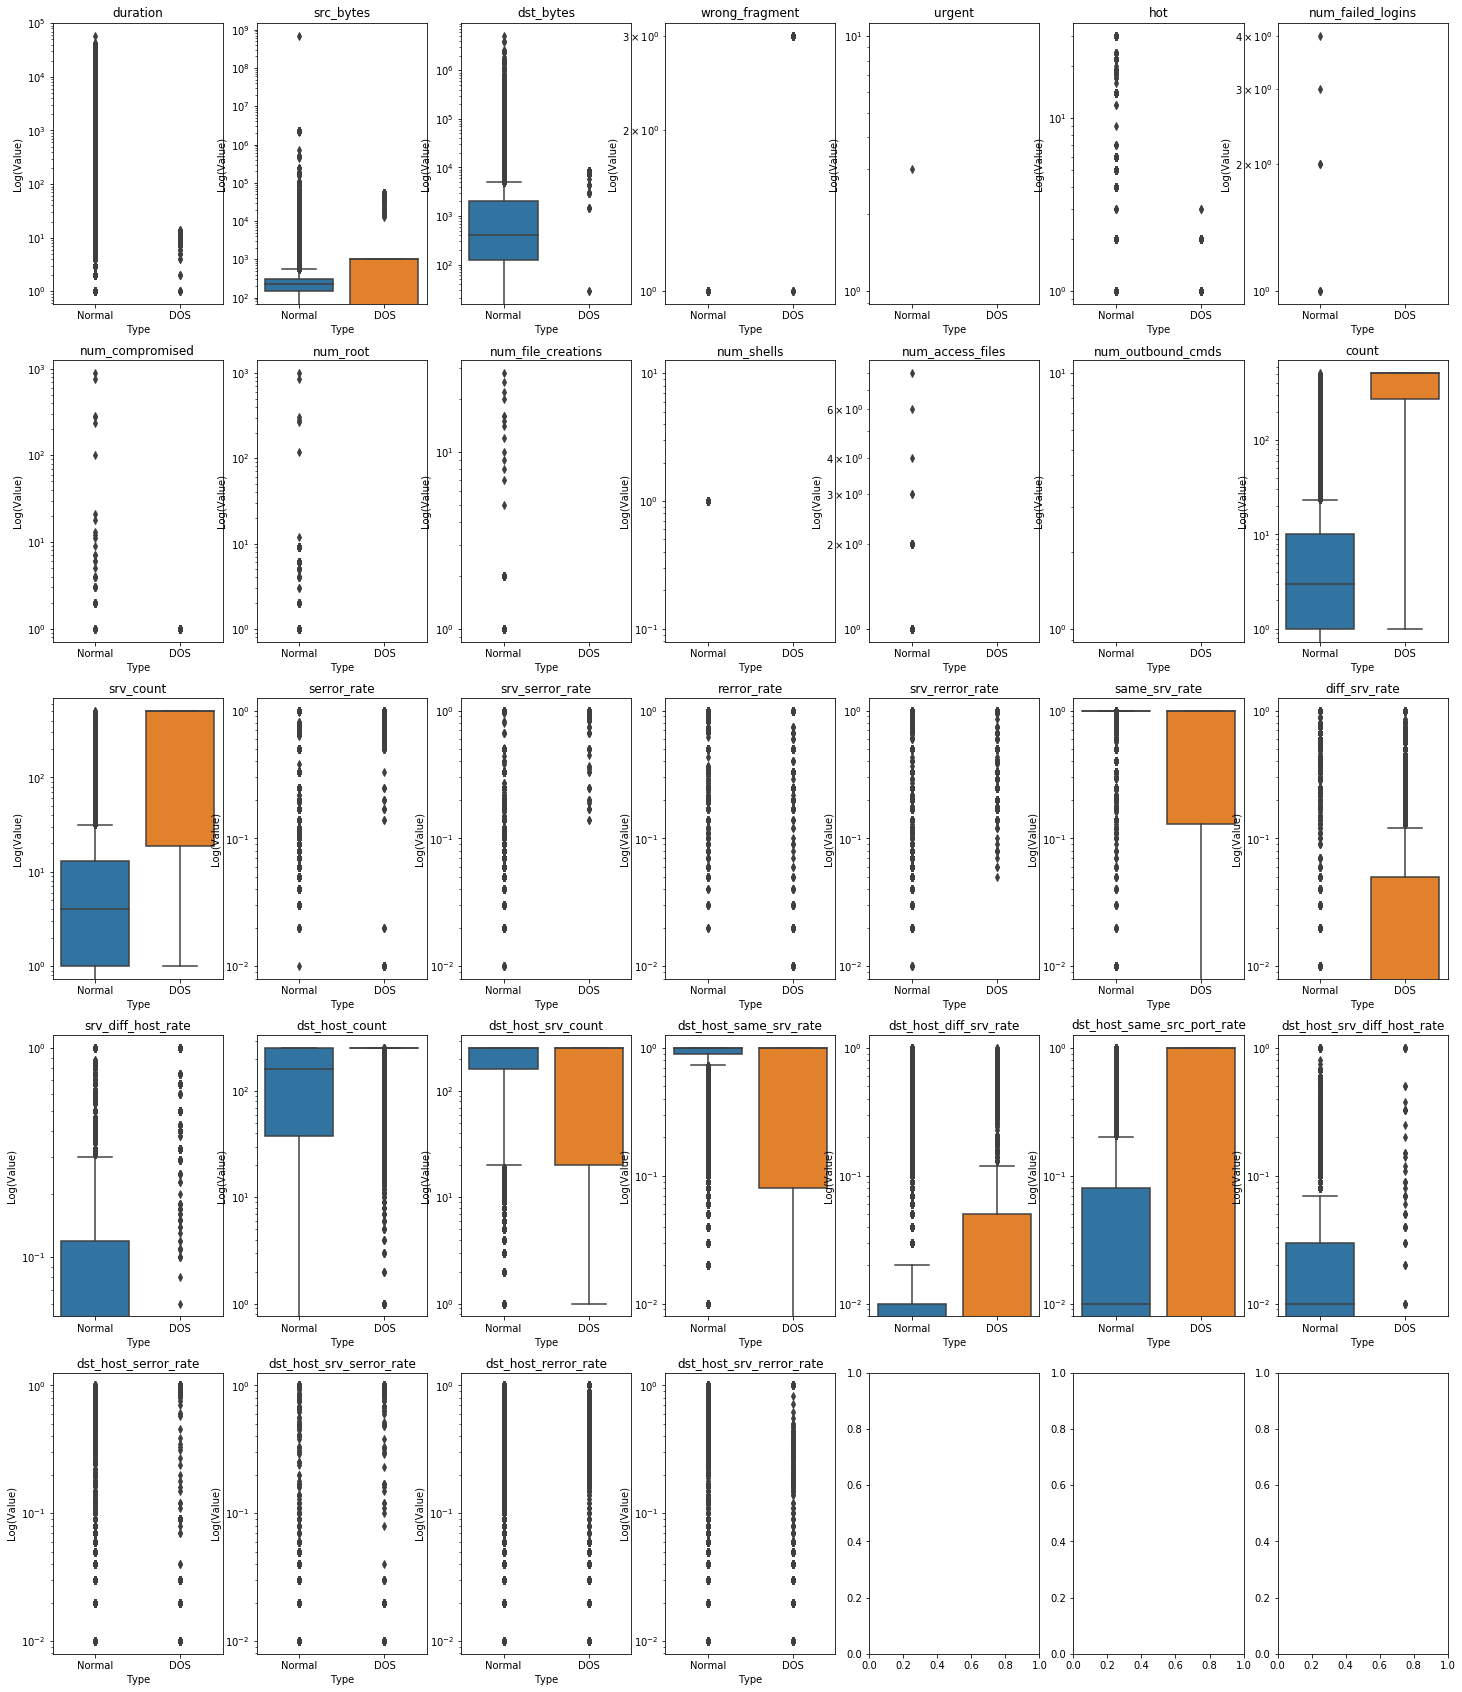

In [15]:
VisNumFeature(df_dos, method = 'boxplot', attack_type = 'DOS',scale = 'log')

DOS 유형의 공격은 짧은 시간동안 수 많은 접속 시도를 생성한다는 특징을 보이고 있다. 

시각화를 통해 수치형 변수의 분포를 확인해본 결과, 다음과 같은 변수를 통해 공격 유형의 특징을 찾을 수 있었다.

1. DOS 공격 유형은 짧은 시간 동안 많은 접속이 발생한다. (duration, count, srv_count)
2. 짧은 접속 시간으로 인하여 데이터는 거의 발생하지 않는다. (src_bytes, bst_btyes)
3. 일반적인 연결보다 wrong_fragment의 수치가 높은 편이다.
4. 연결 후, 어떠한 작업도 수행하지 않는다. 오직 많은 연결을 통해 서버를 과부하 시키는 행동을 반복한다. (num_root, num_file_creations, num_shell, num_access_files)

#### R2L(Remote to Local)
권한 없는 사용자가 외부에서 접근 권한을 얻으려 하는 공격 유형이다.

In [26]:
df_rtl = df.loc[df['Type'] == 'R2L']
print("Num of R2L Type Packet: {}".format(df.loc[df['Type'] == 'R2L'].shape[0]))

Num of R2L Type Packet: 1126


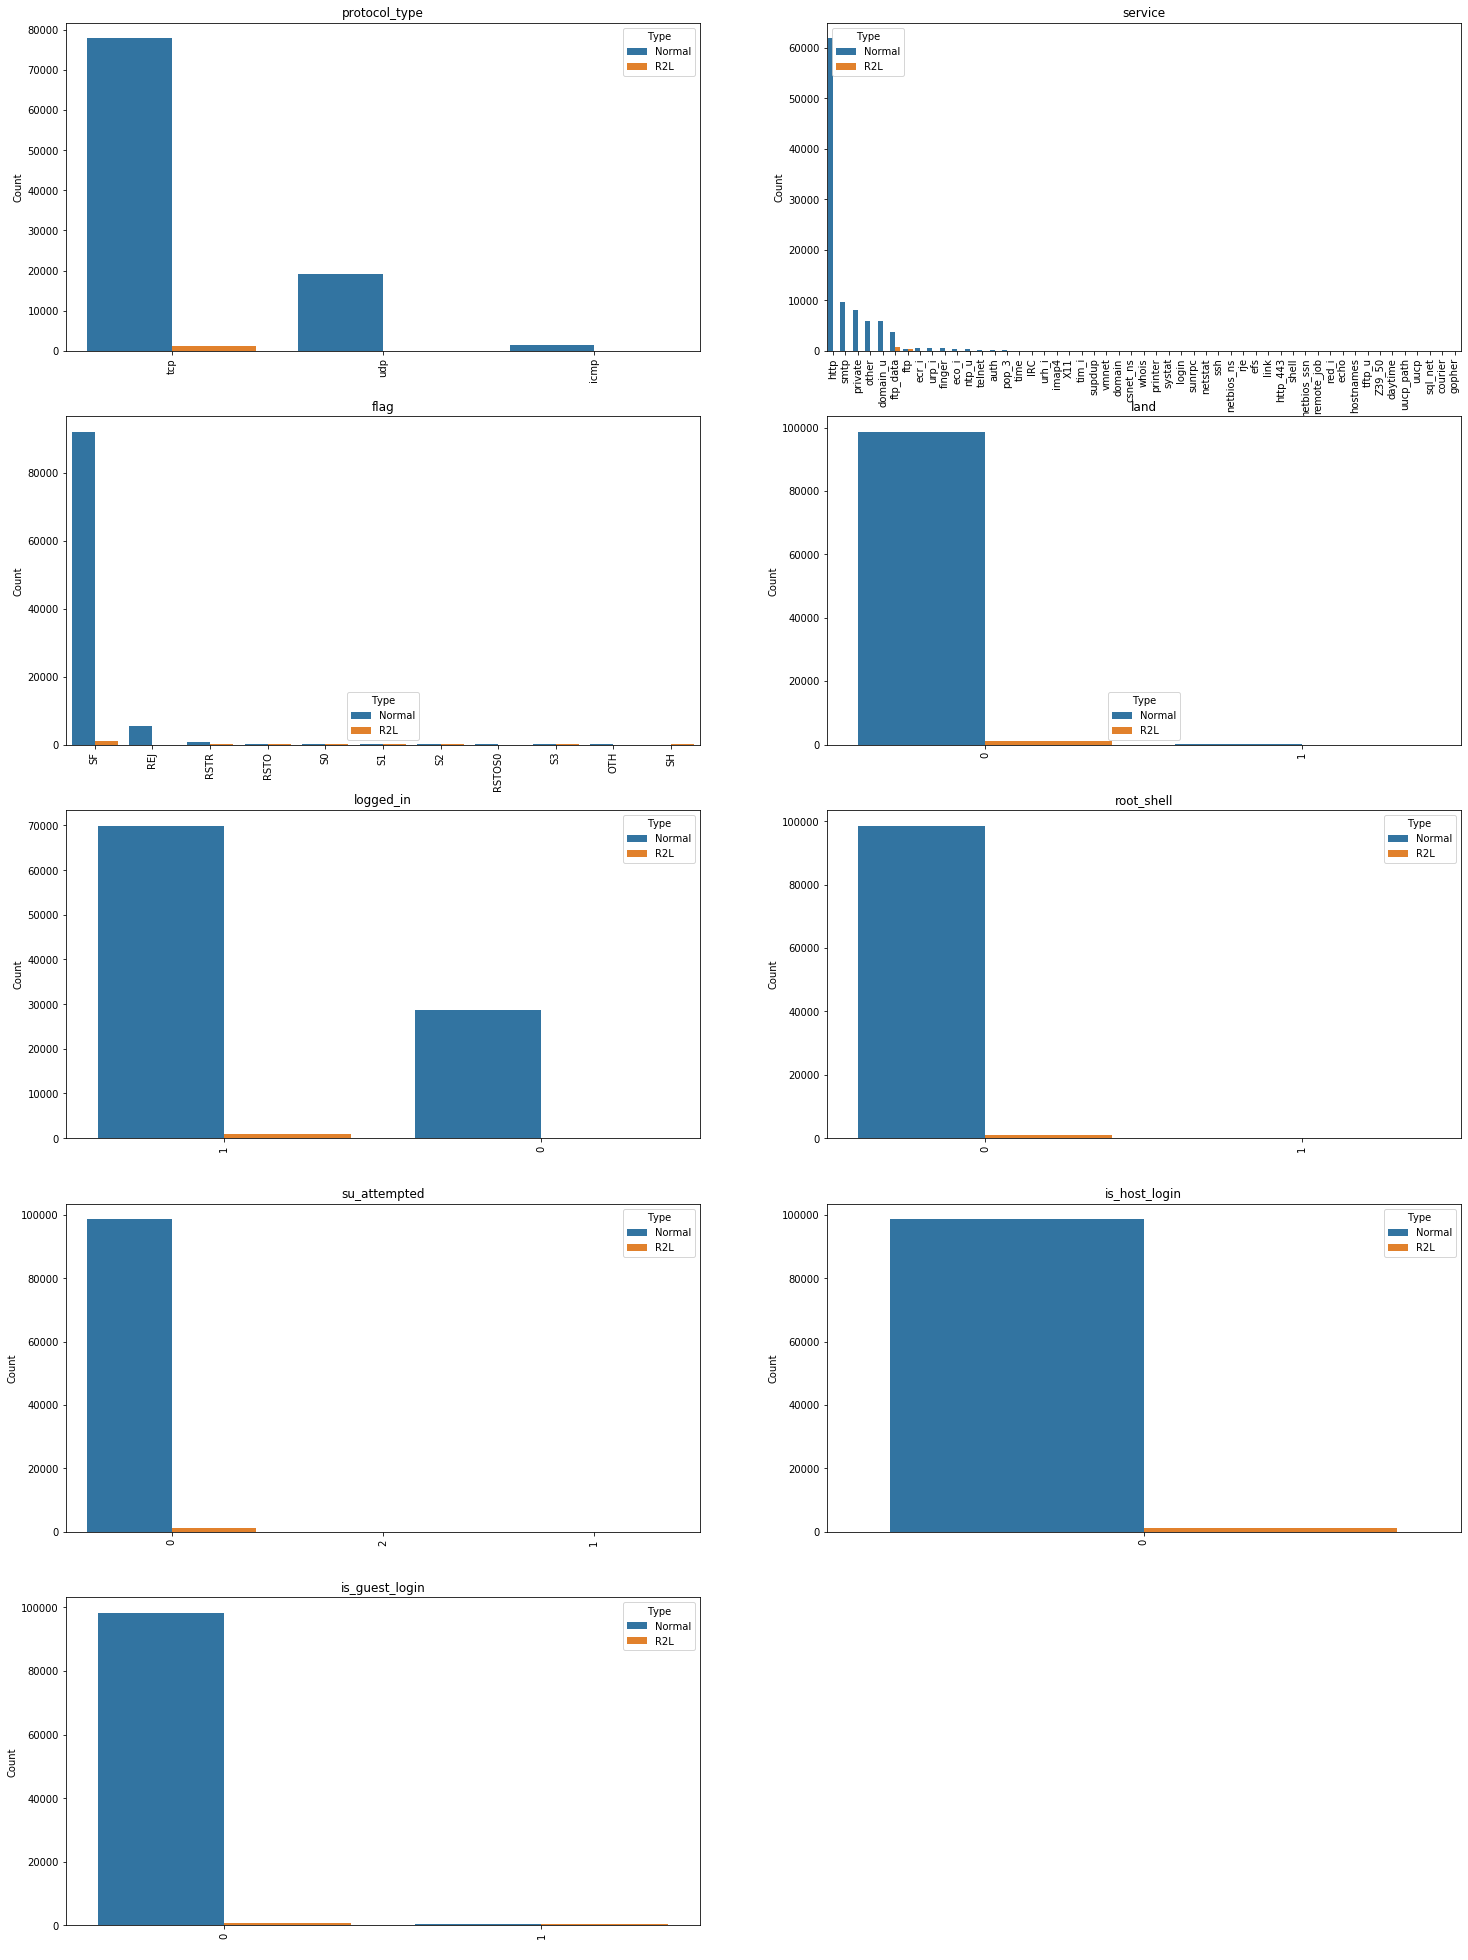

In [19]:
VisCatFeature(df, attack_type = 'R2L')

R2L 유형 공격의 특징은 다음과 같다. 마찬가지로 그래프를 해석할 때, 단순히 공격 연결 유형의 빈도수와 정상적인 연결의 빈도수를 비교하기에는 샘플의 수가 차이나므로, 비율을 고려하여 특징을 확인했다.

1. R2L 공격 유형은 대부분 TCP 프로토콜 유형에서 발생했다는 것을 알 수 있다. 
2. 서비스 유형은 ftp_data 유형과 ftp 유형에서 많이 발생했다는 것을 알 수 있다.
3. R2L 공격 유형은 Guest Login 비율이 상대적을 높다는 것을 알 수 있다.

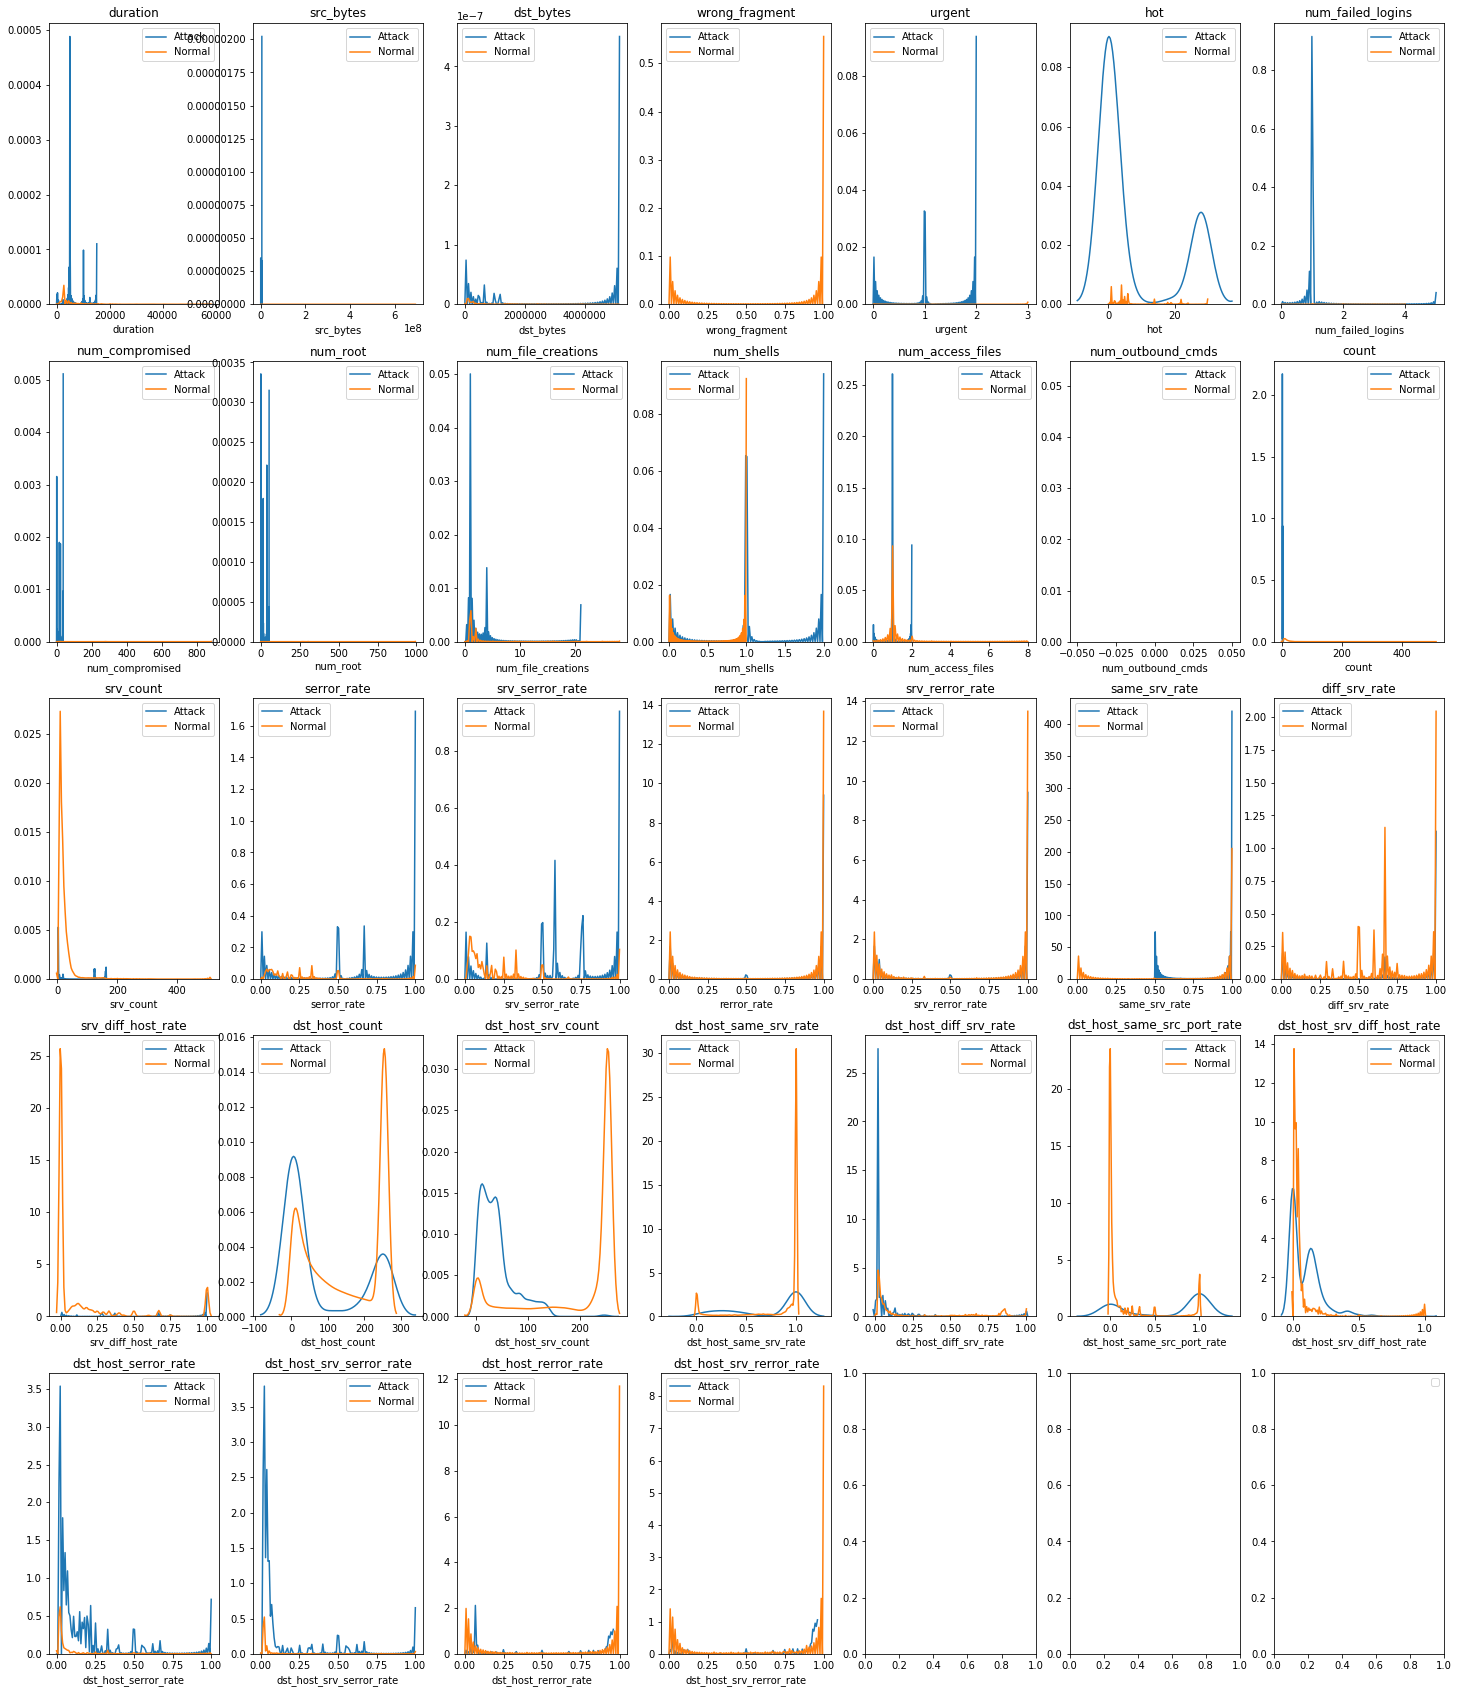

In [39]:
VisNumFeature(df_rtl, method = 'hist')

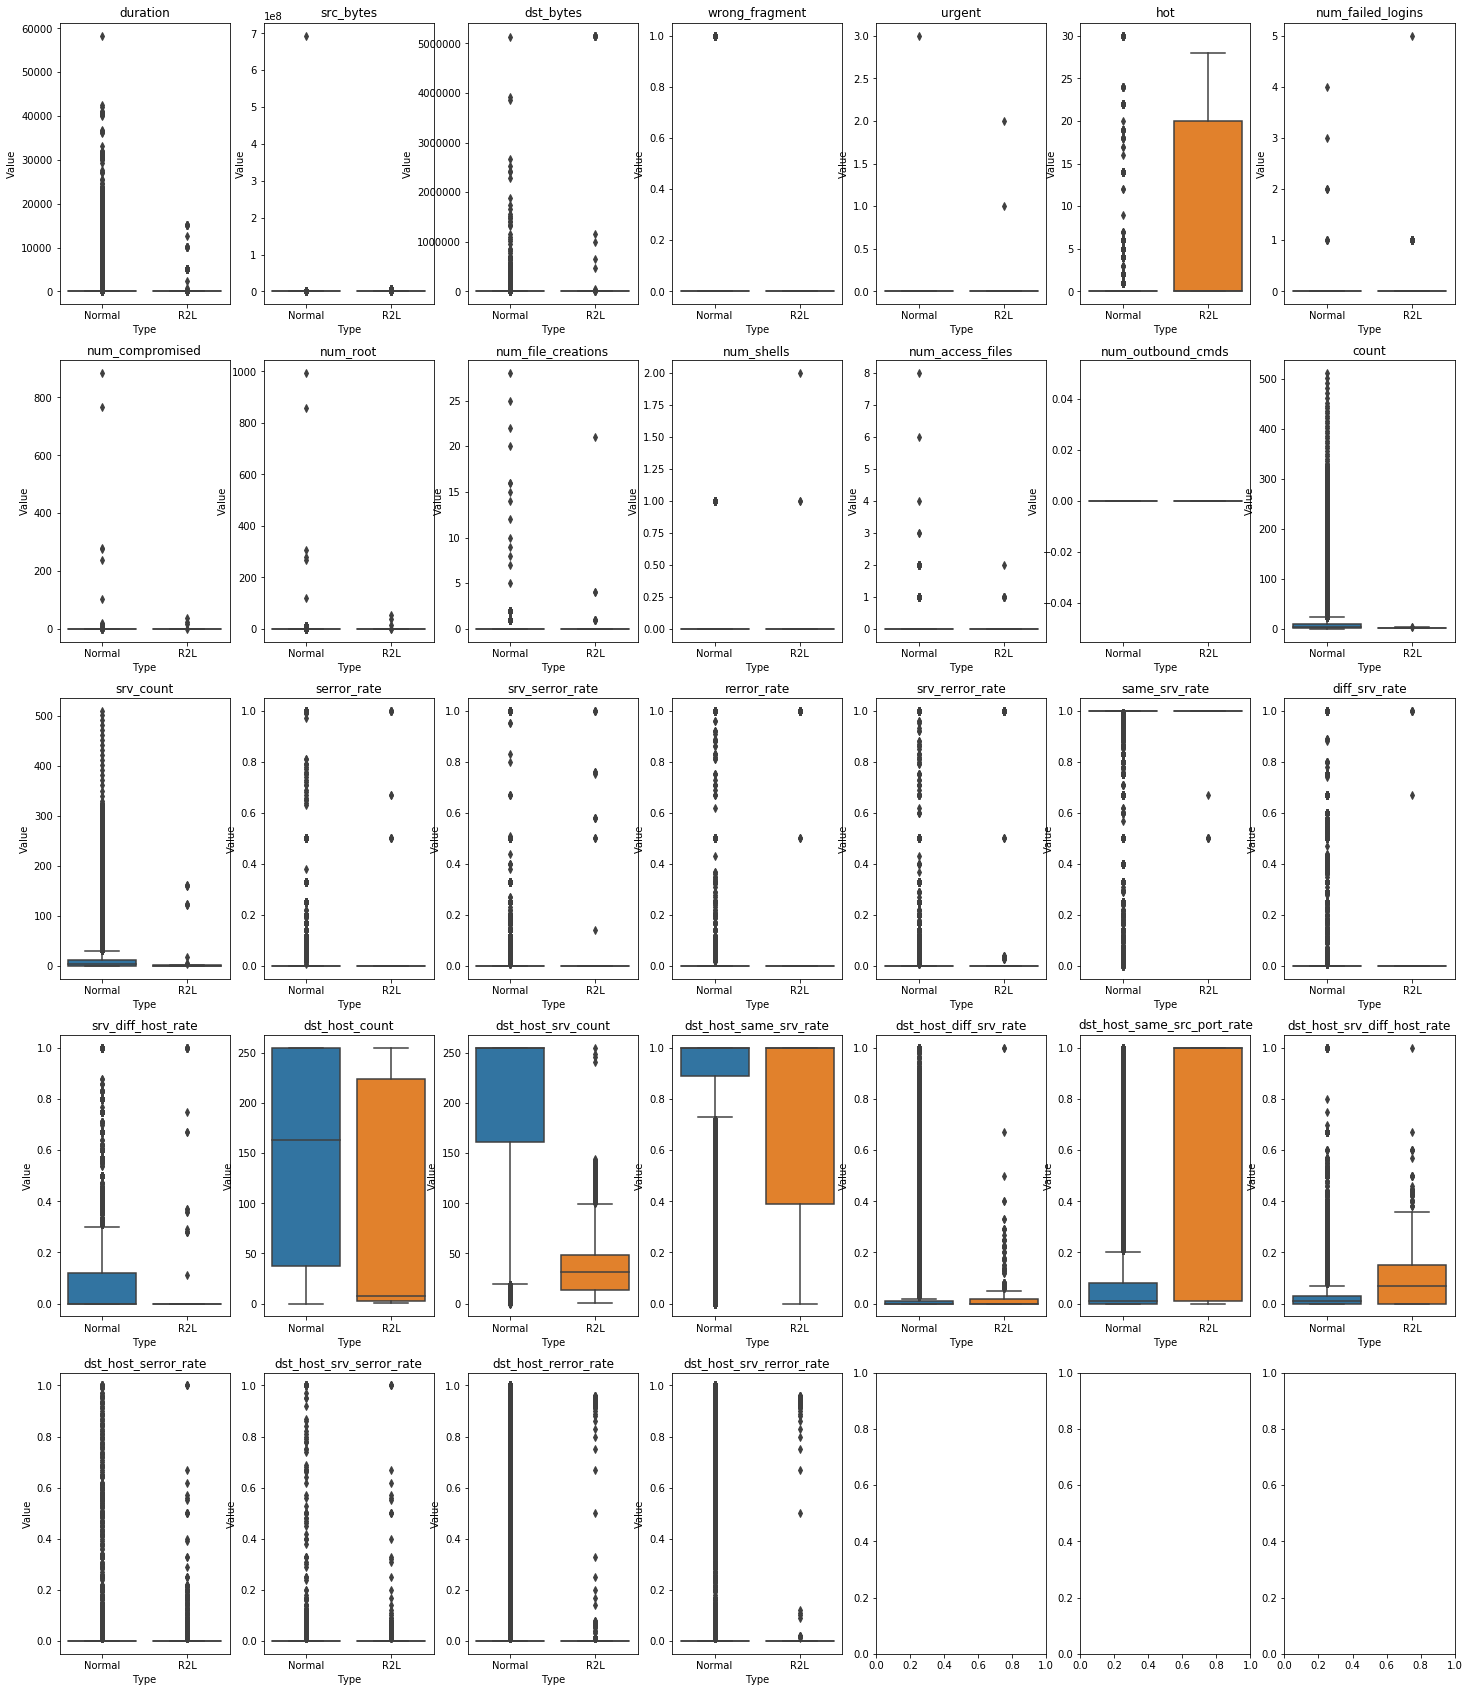

In [40]:
VisNumFeature(df_rtl, method = 'boxplot', attack_type = 'R2L')

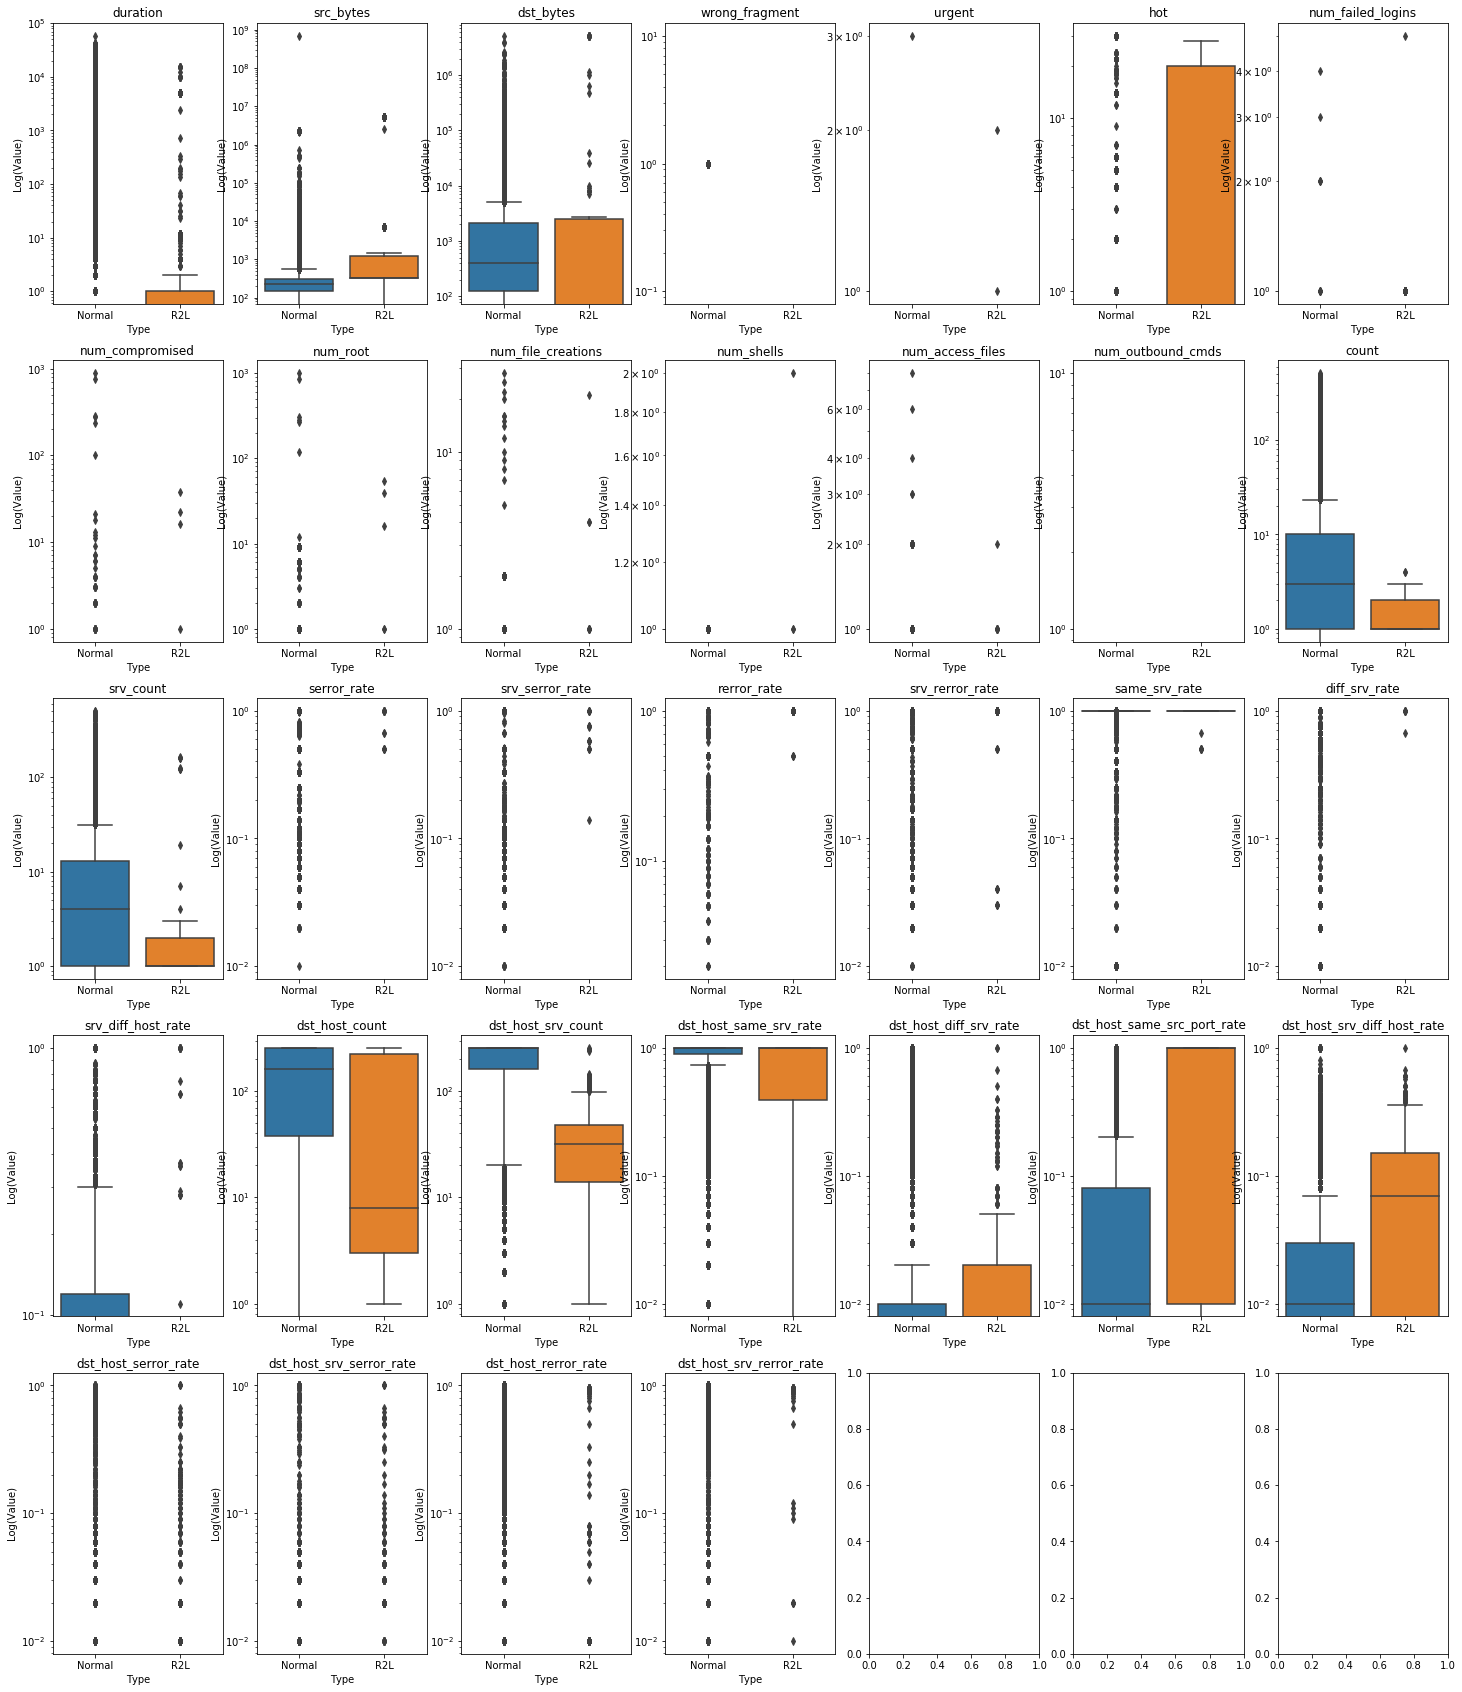

In [41]:
VisNumFeature(df_rtl, method = 'boxplot', attack_type = 'R2L',scale = 'log')

#### U2R(User to Root)

In [42]:
df_utr = df.loc[df['Type'] == 'U2R']
print("Num of U2R Type: {}".format(df_utr.shape))

Num of U2R Type: (52, 43)


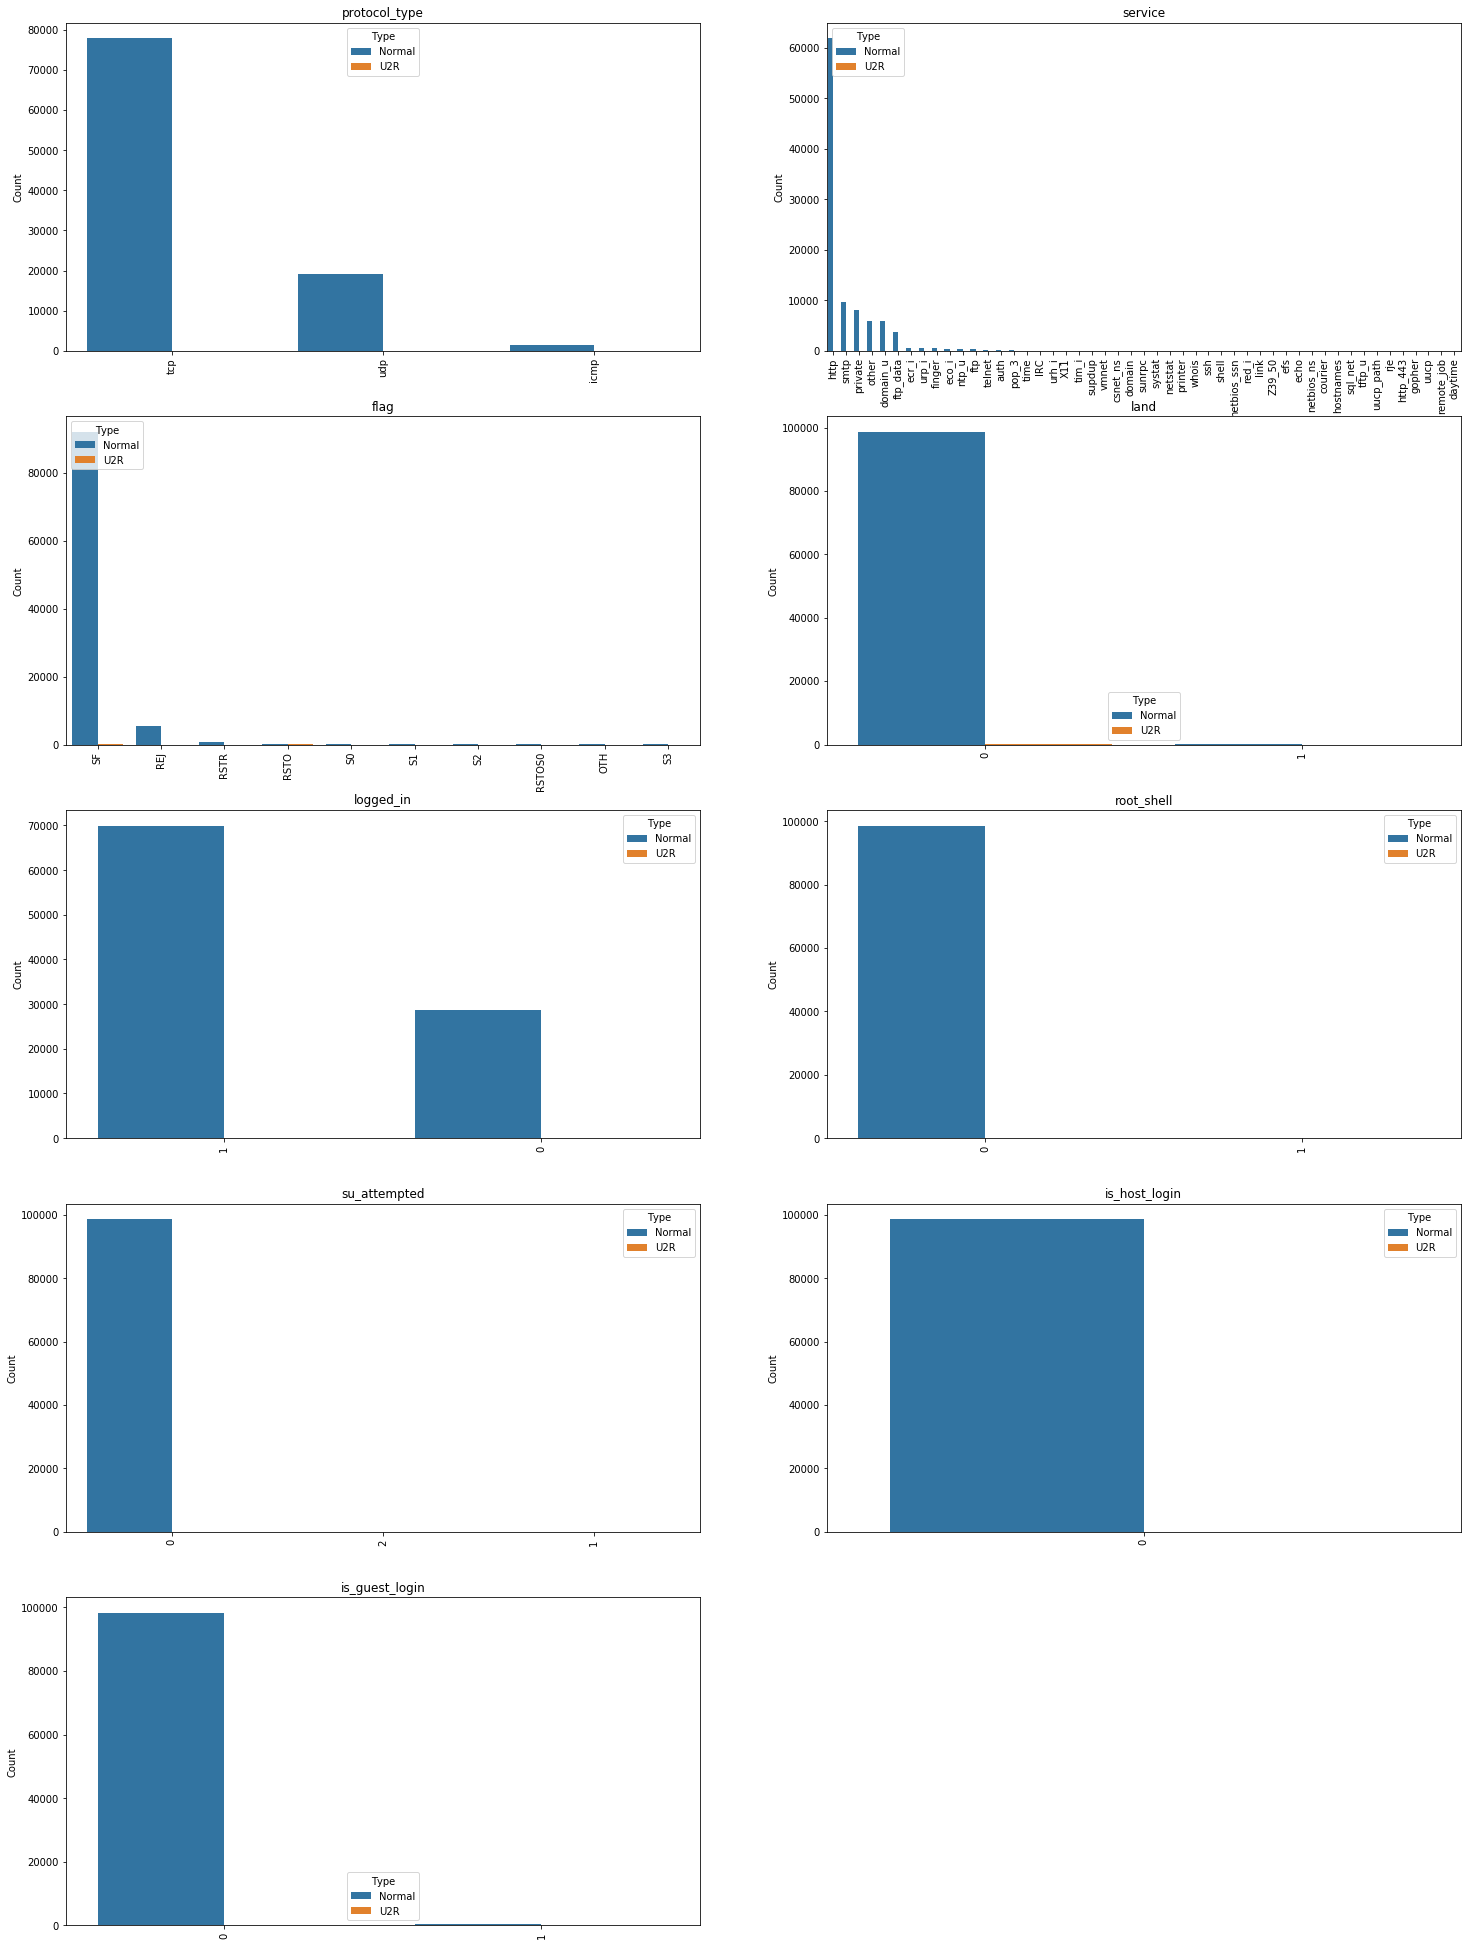

In [44]:
VisCatFeature(df, attack_type = 'U2R')

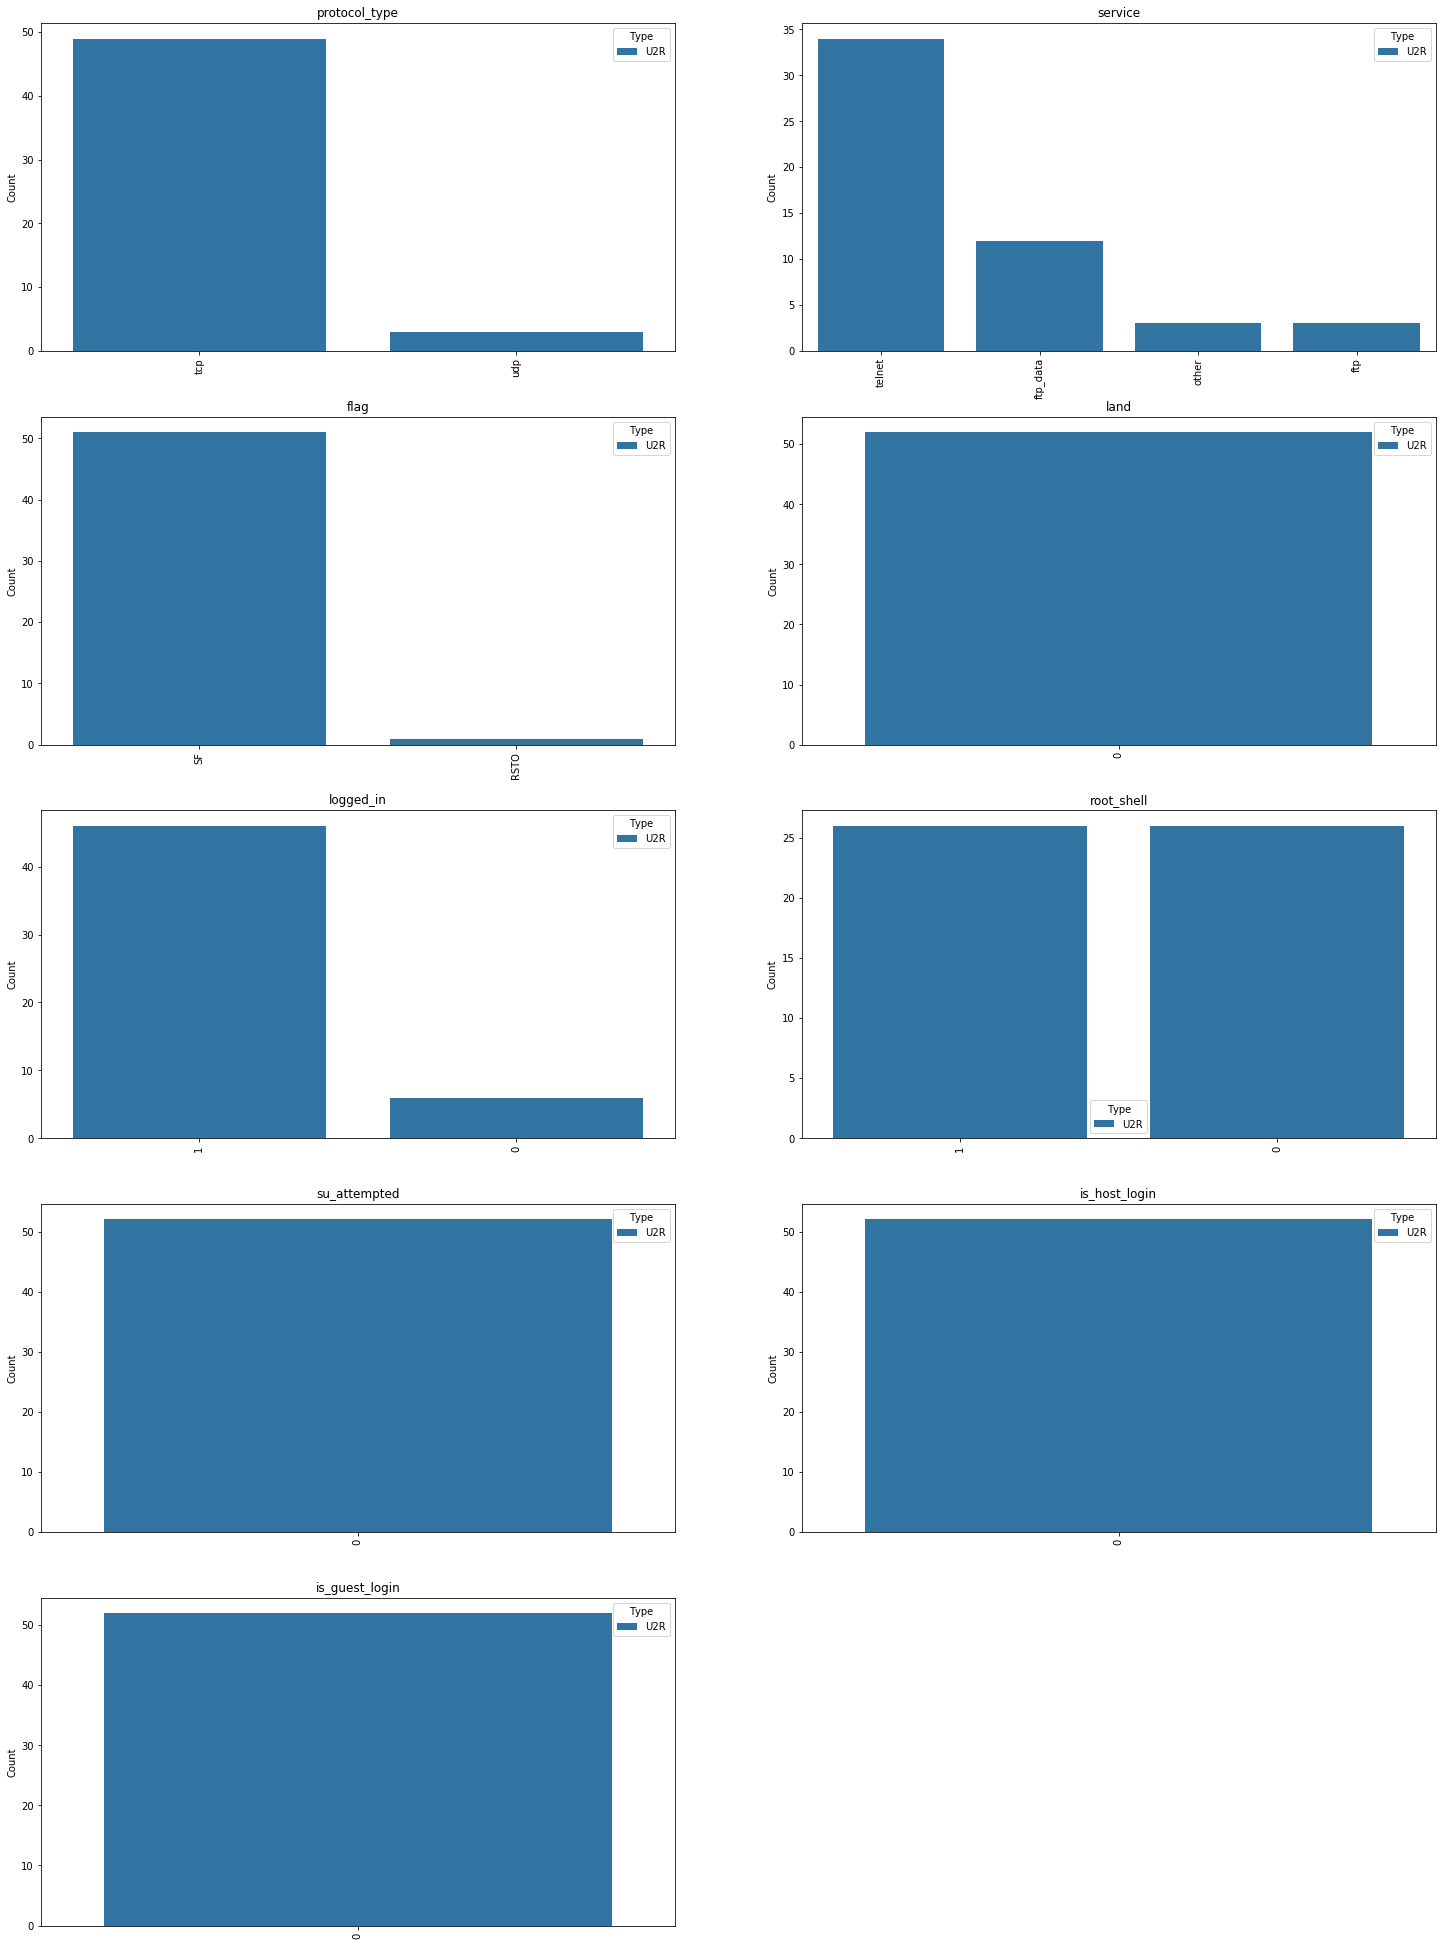

In [45]:
VisCatFeature(df_utr, attack_type = 'U2R')

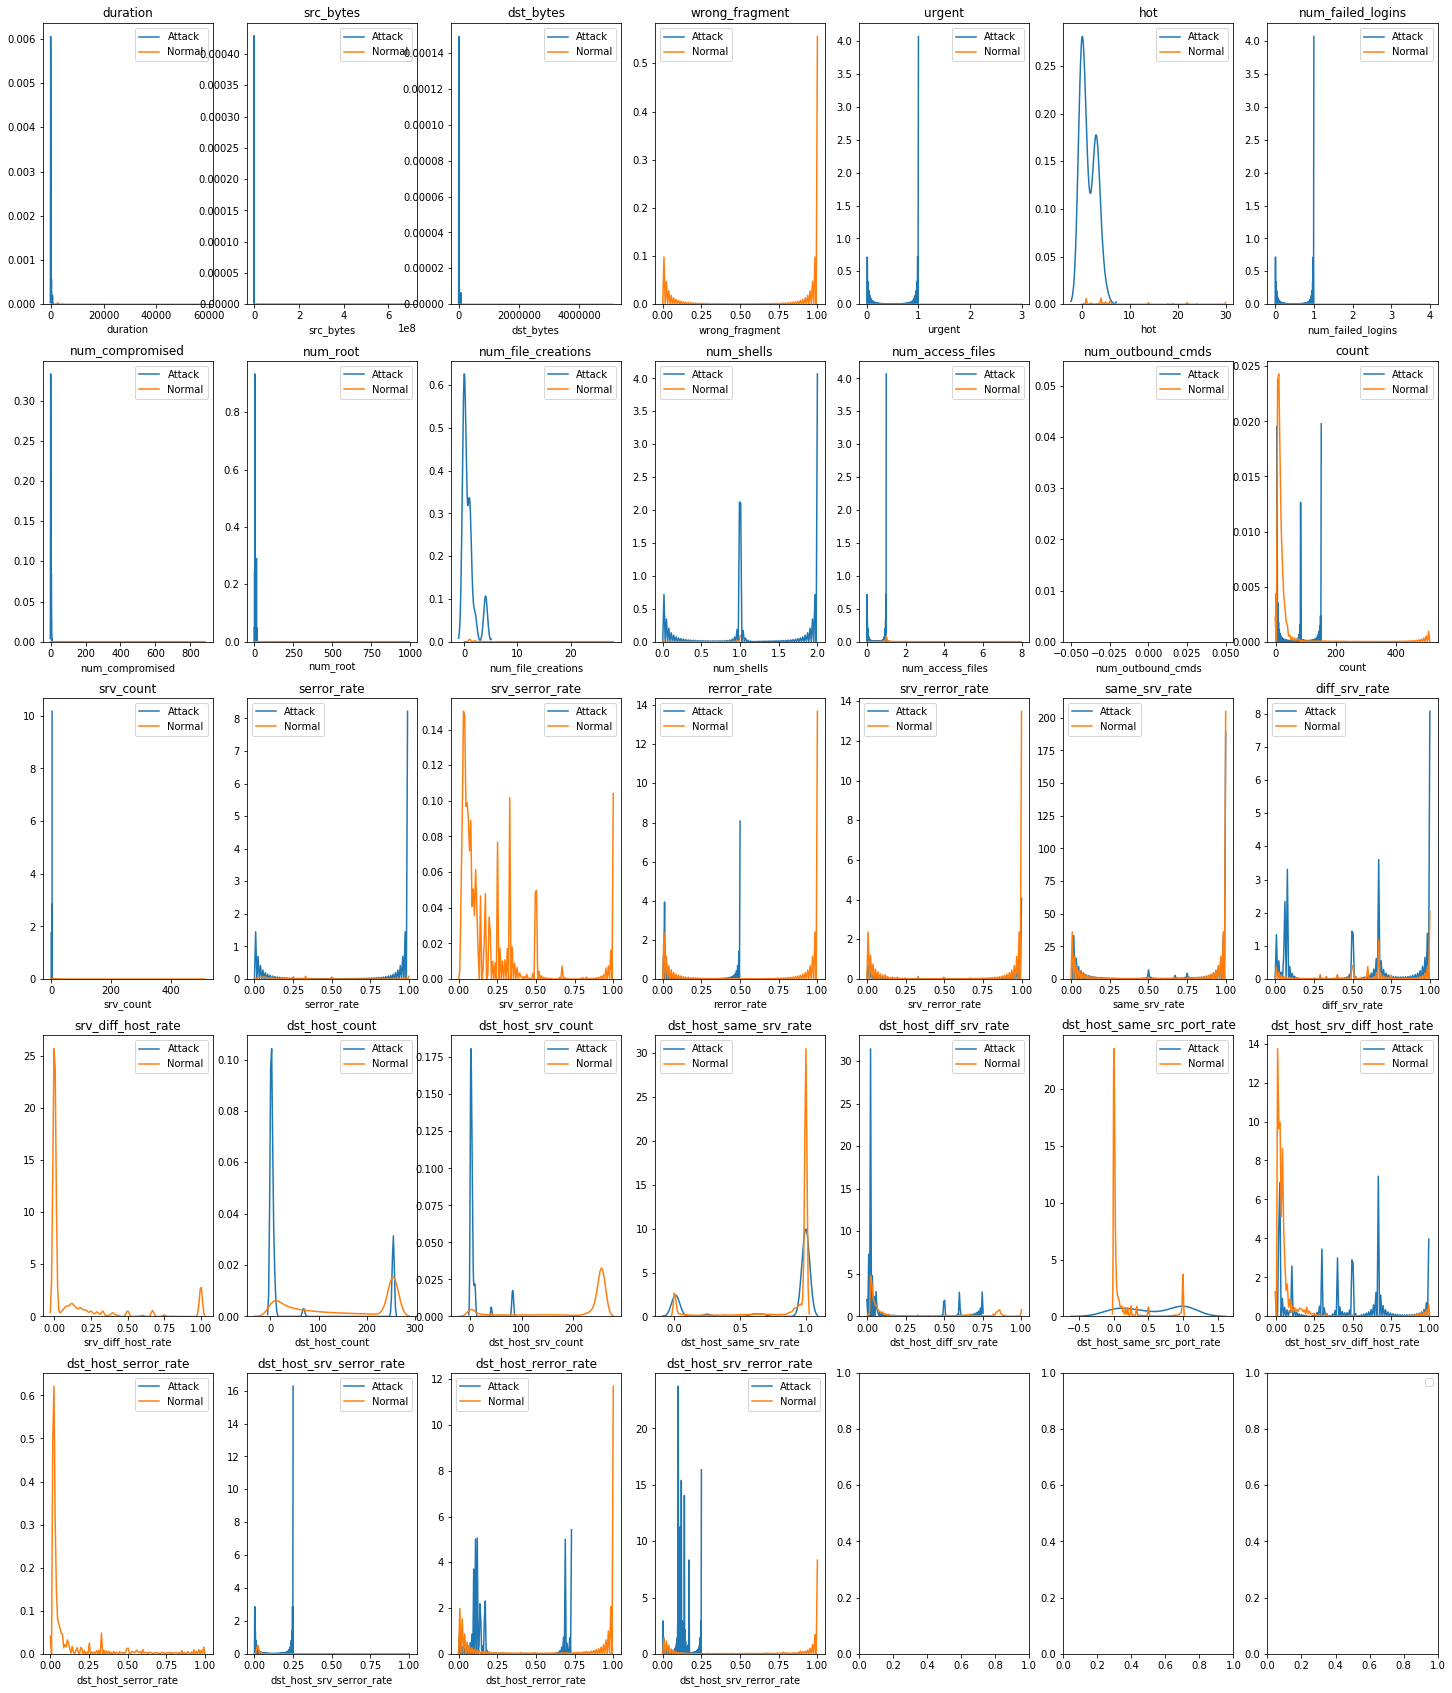

In [46]:
VisNumFeature(df_utr, method = 'hist')

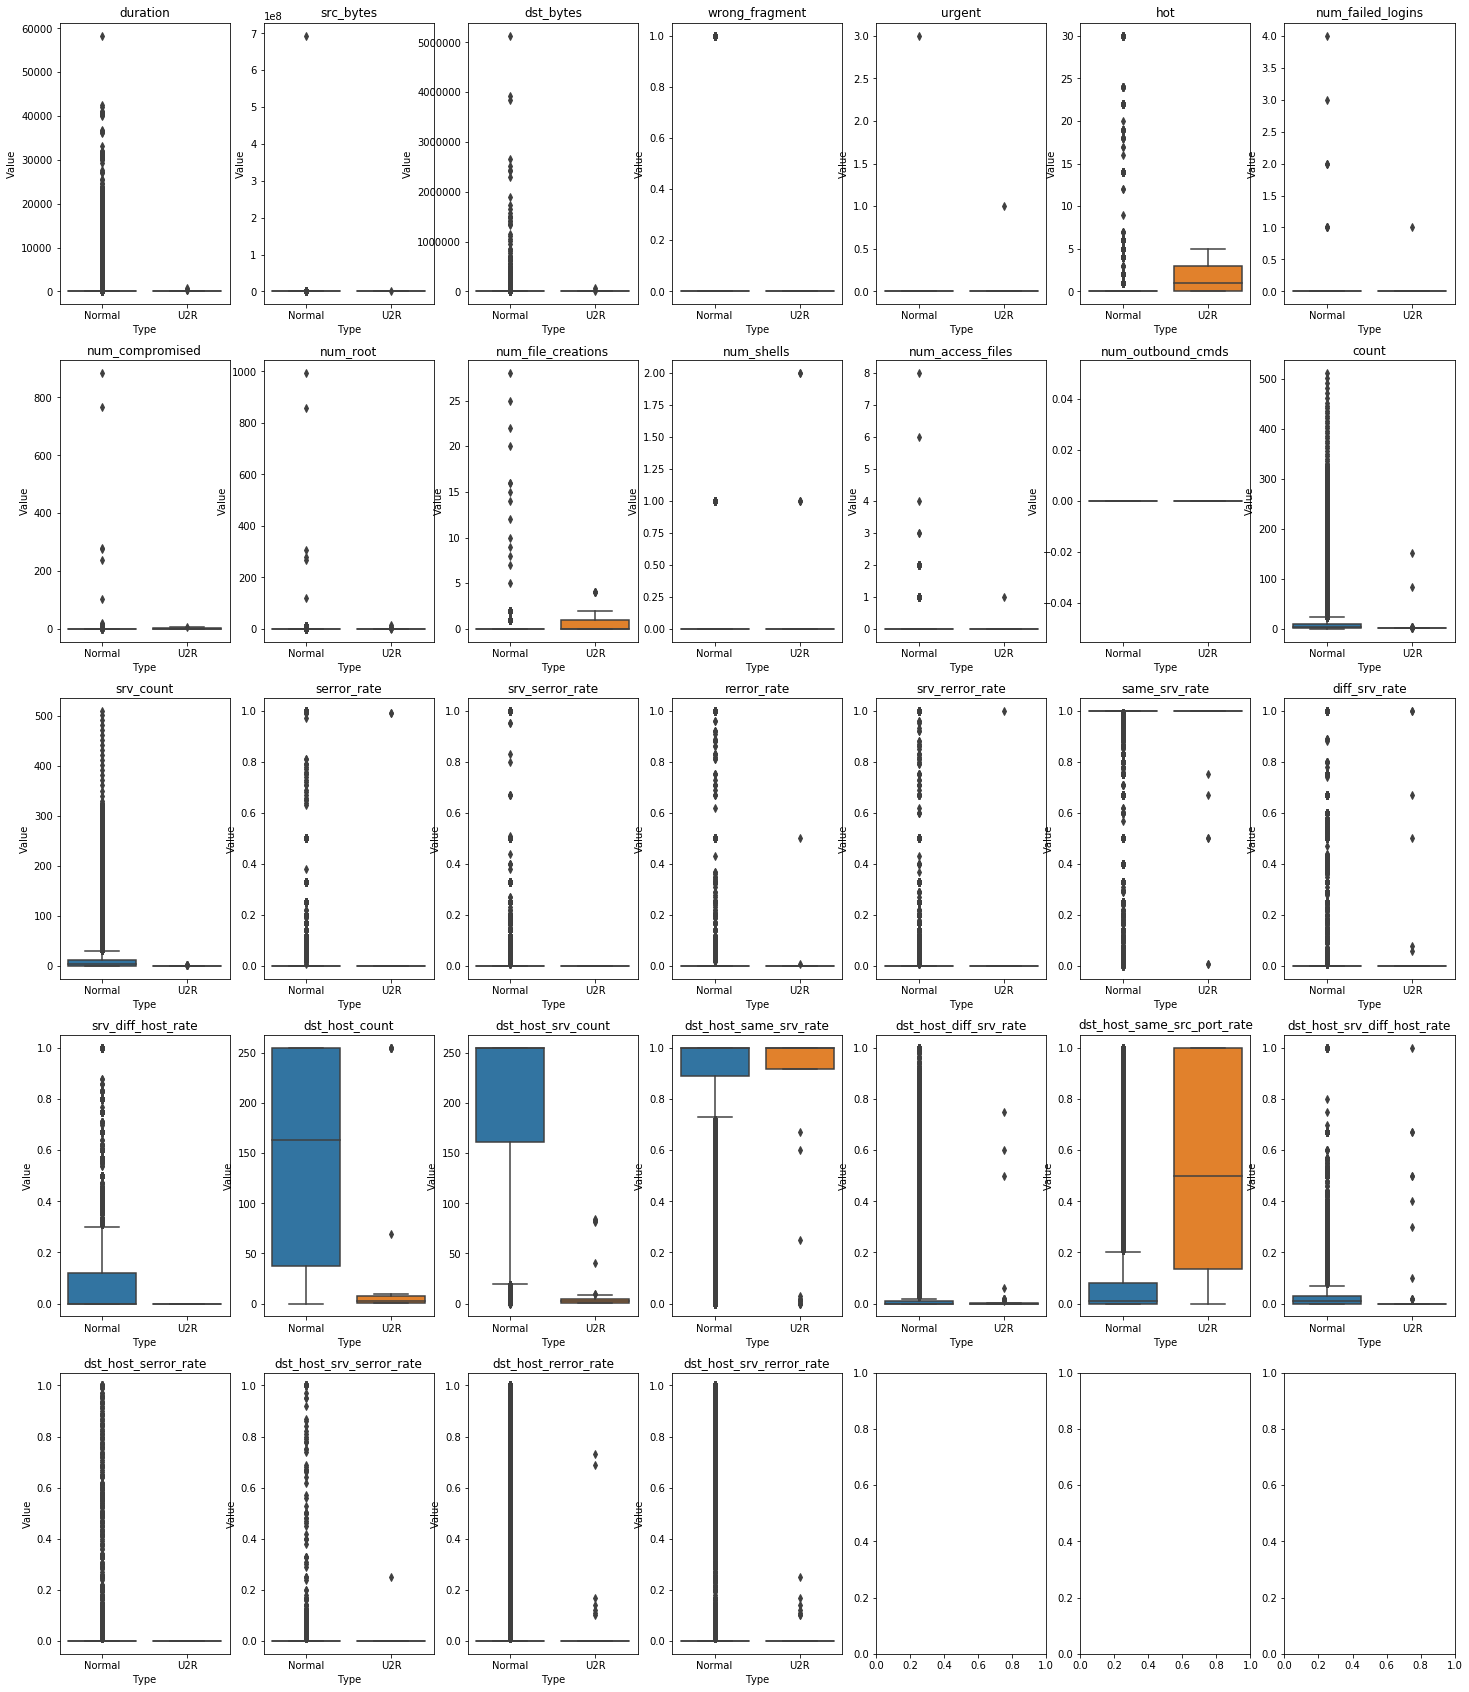

In [49]:
VisNumFeature(df_utr, method = 'boxplot', attack_type = 'U2R')

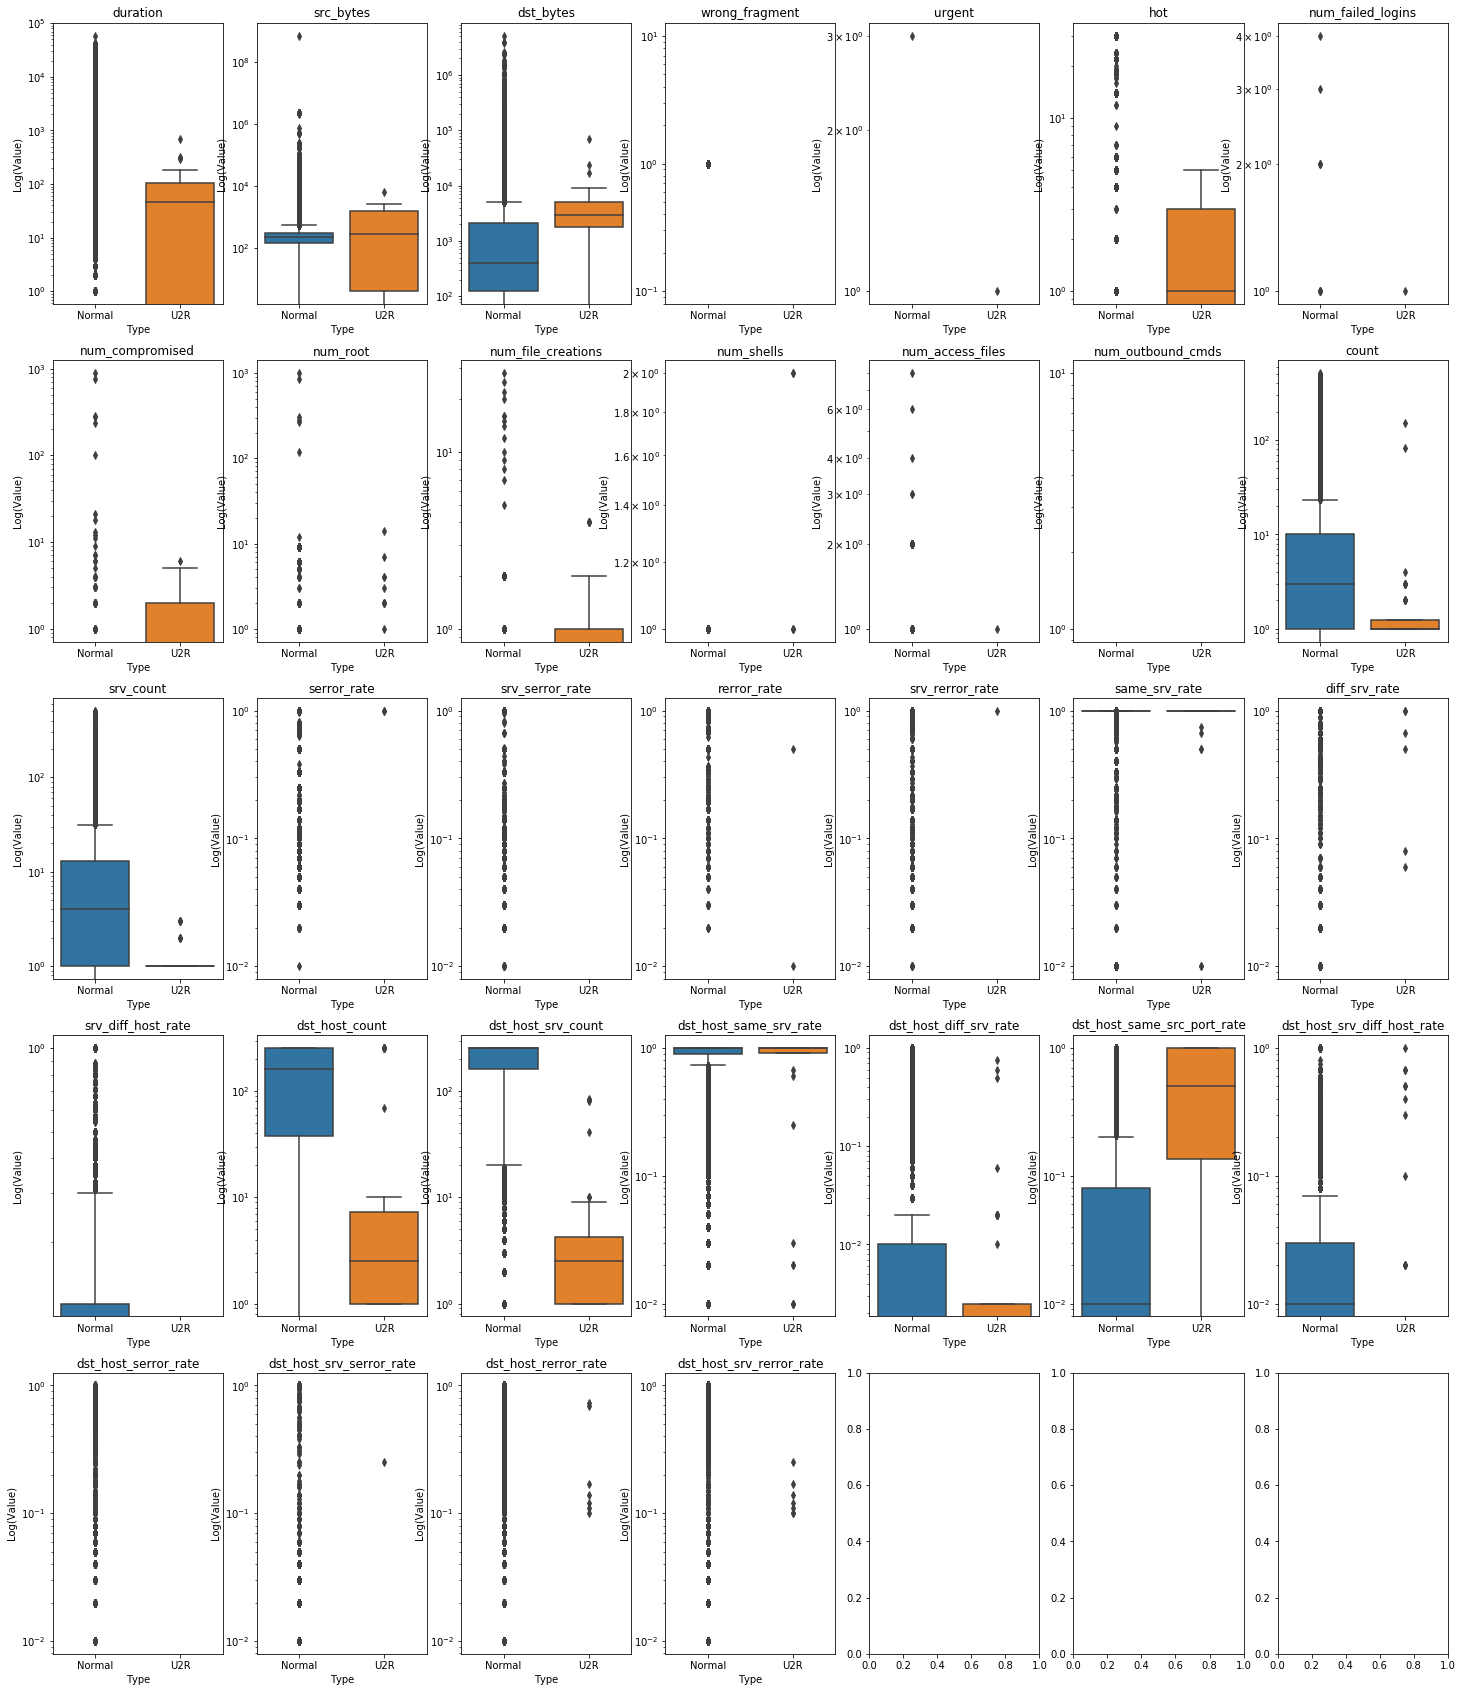

In [48]:
VisNumFeature(df_utr, method = 'boxplot', attack_type = 'U2R',scale = 'log')

#### Probing

In [53]:
df_probe = df.loc[df['Type'] == 'Probe']
print("Num of Probe Type: {}".format(df_probe.shape))

Num of Probe Type: (3067, 43)


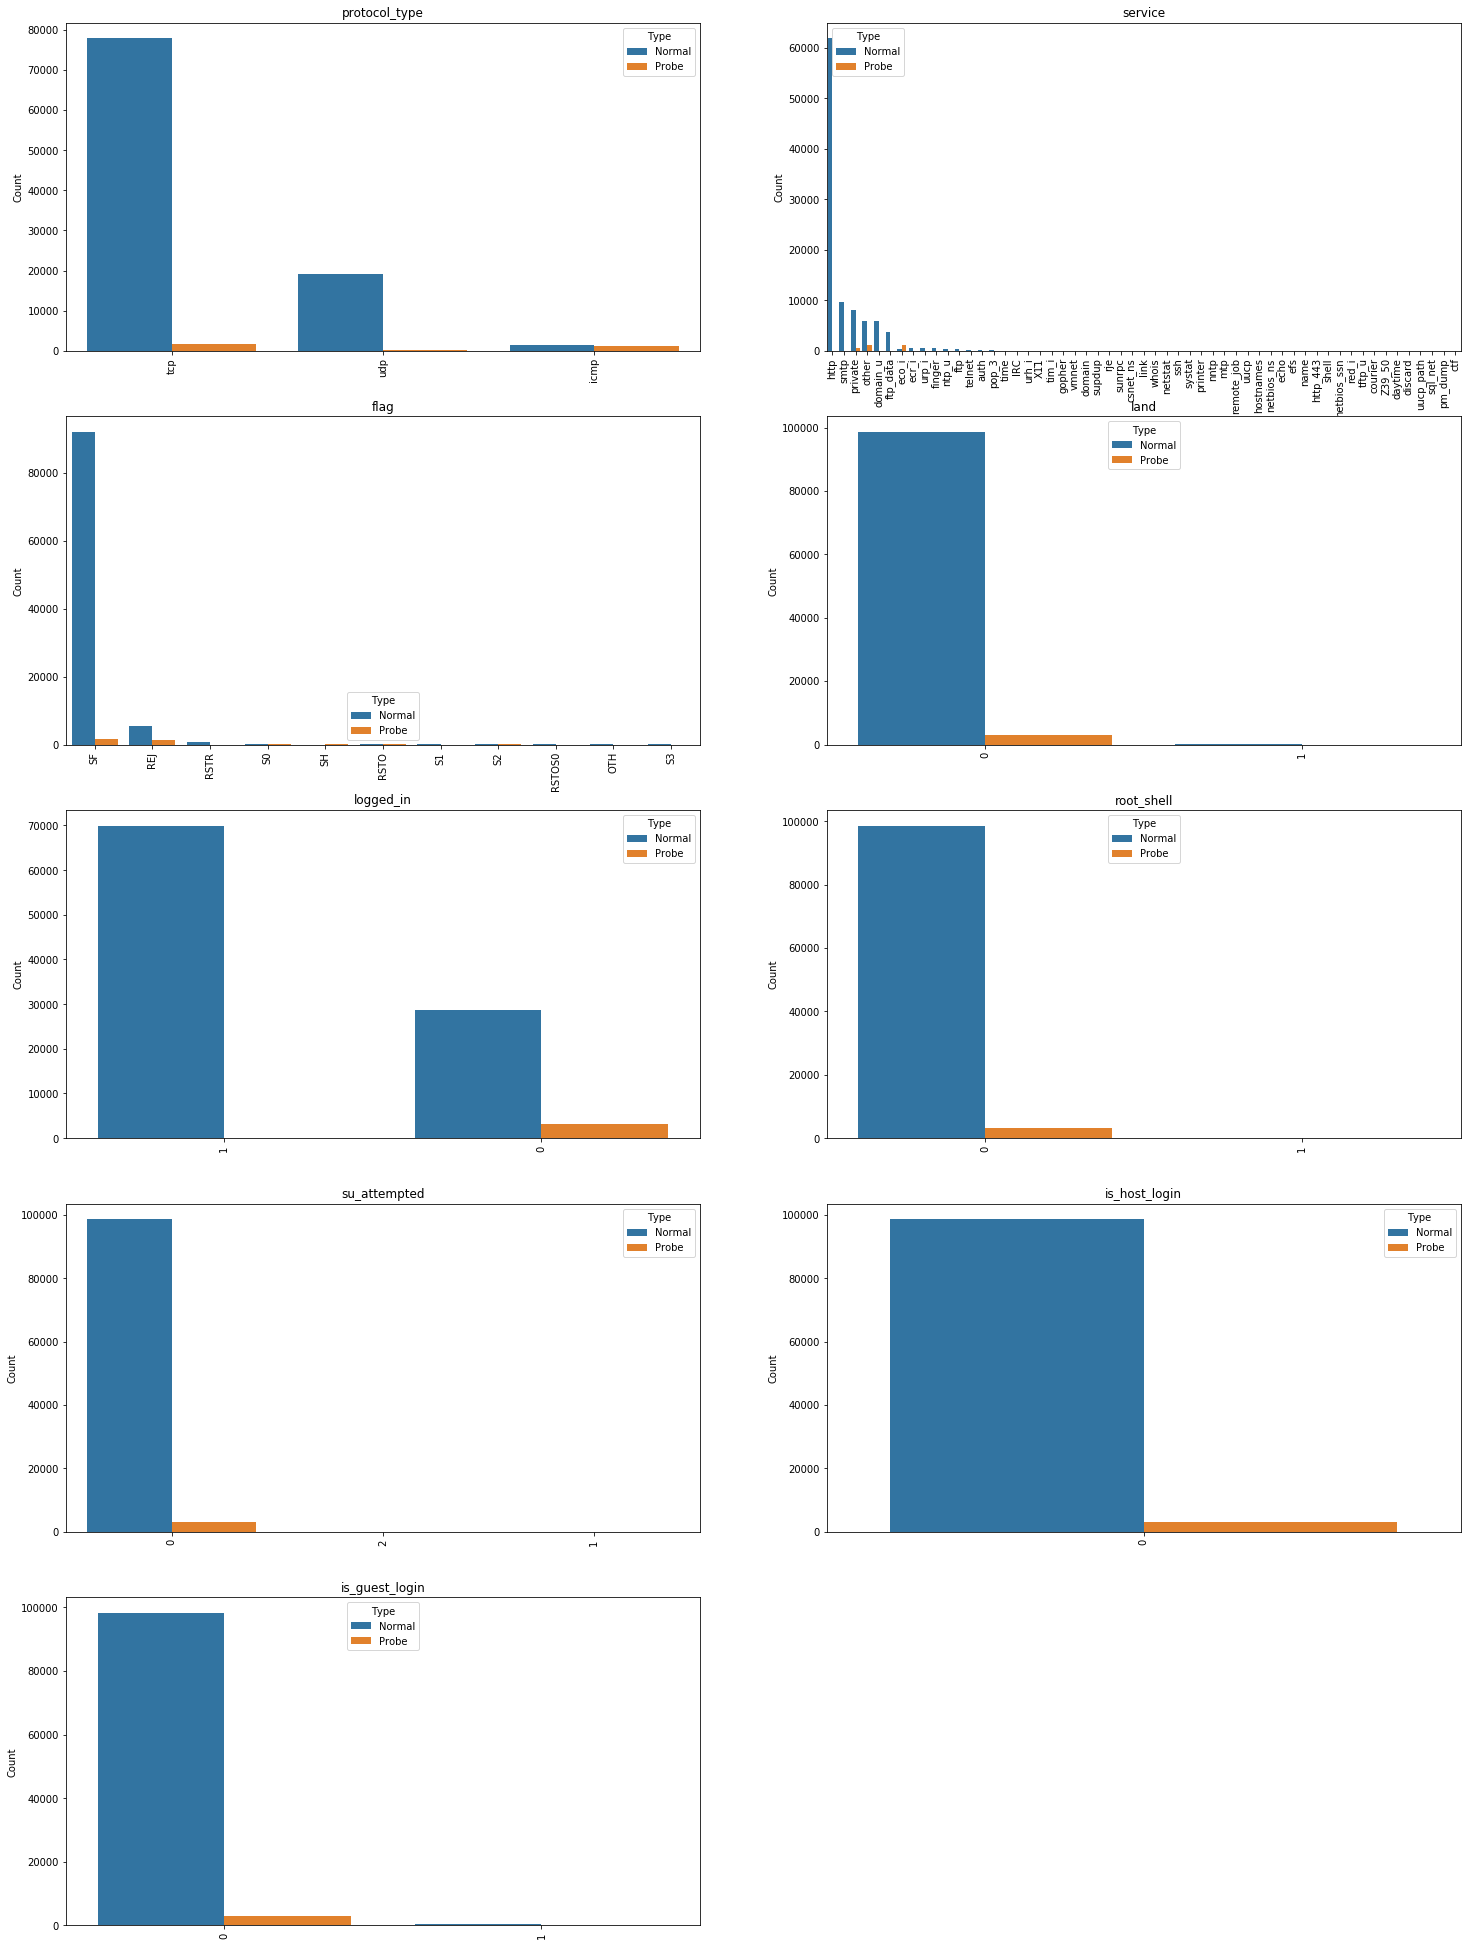

In [54]:
VisCatFeature(df, attack_type = 'Probe')

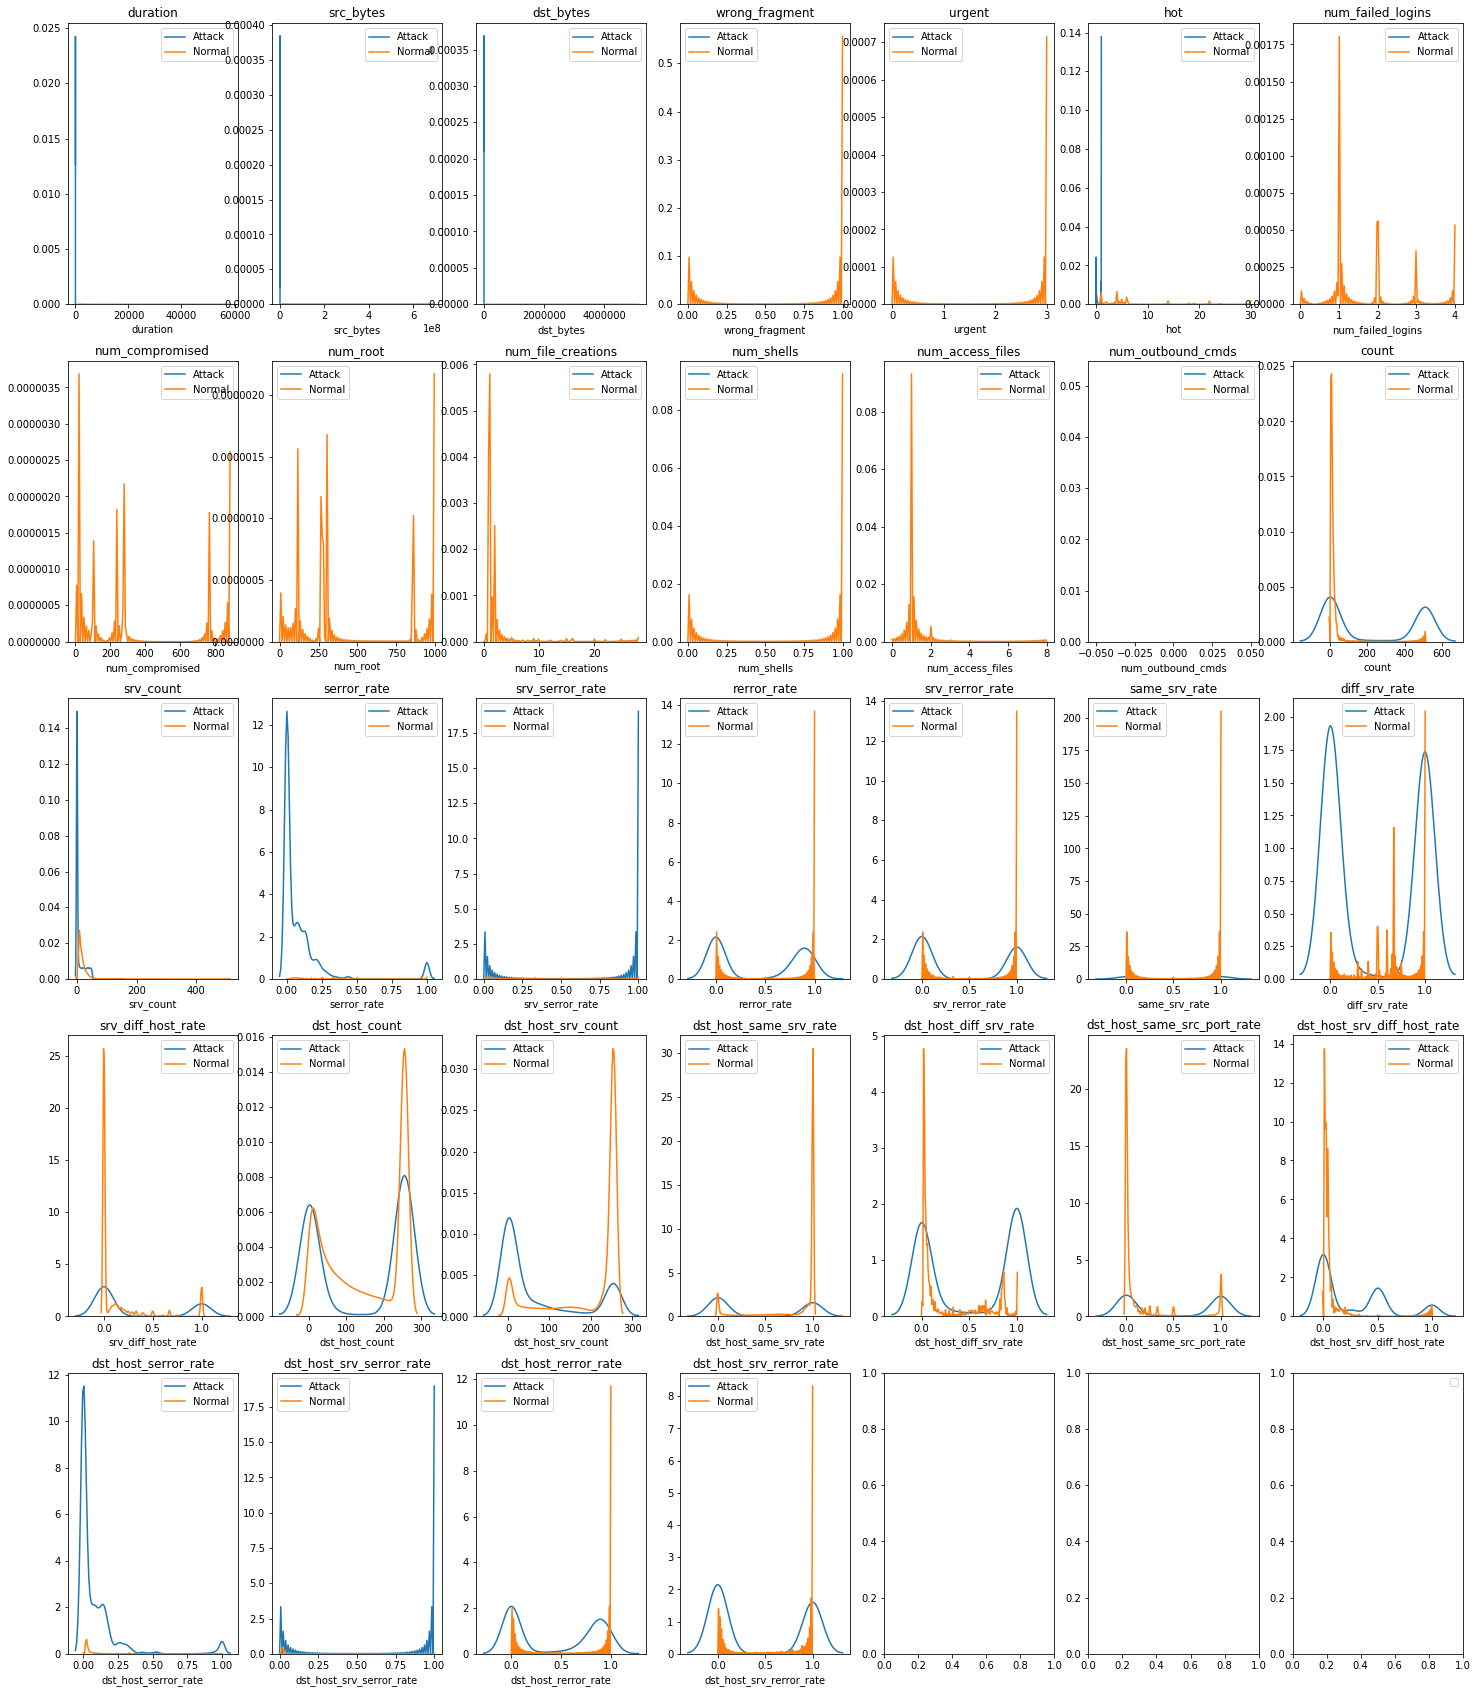

In [55]:
VisNumFeature(df_probe, method = 'hist')

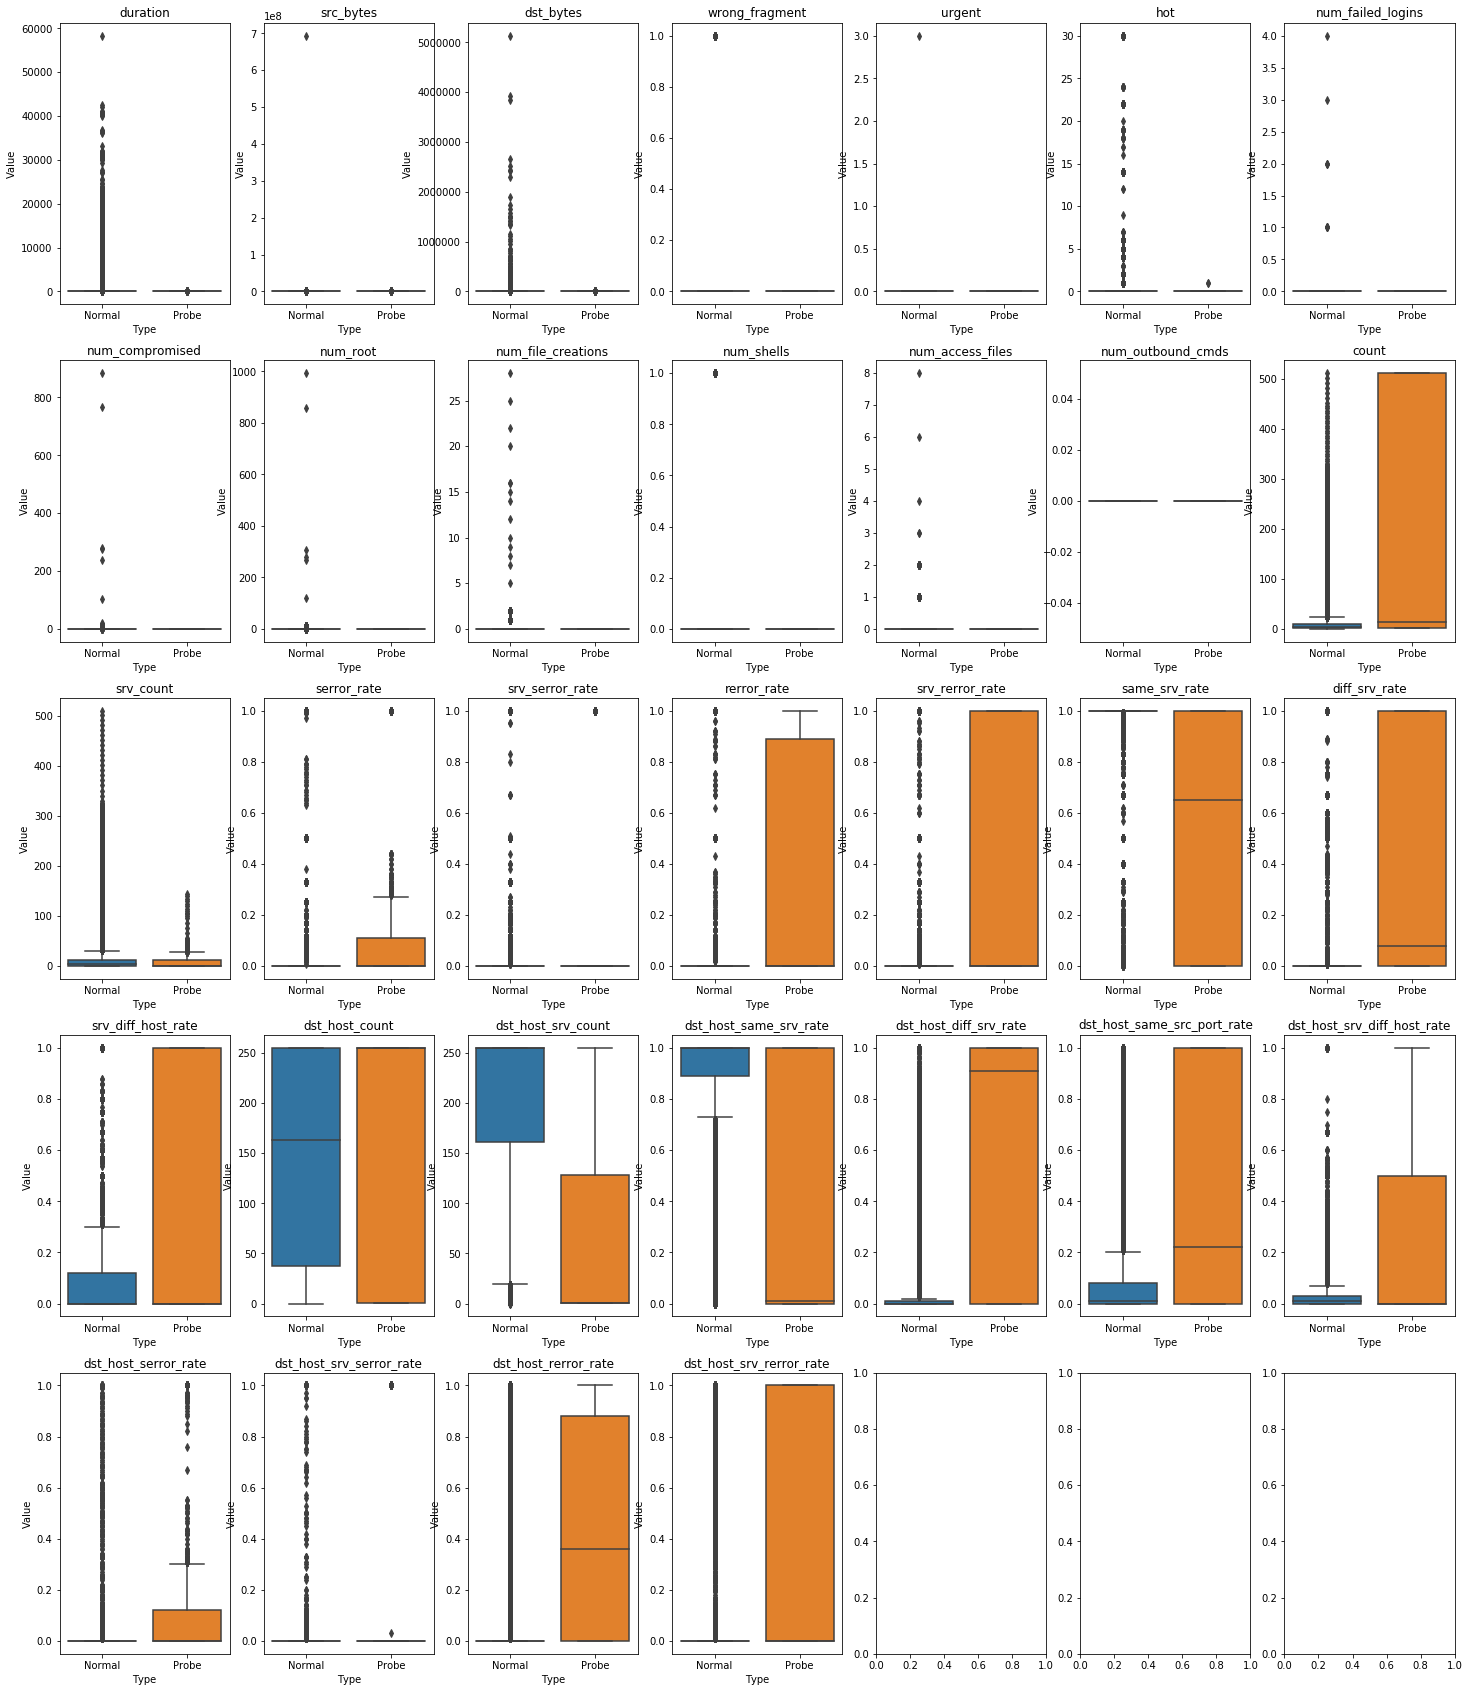

In [56]:
VisNumFeature(df_utr, method = 'boxplot', attack_type = 'Probe')

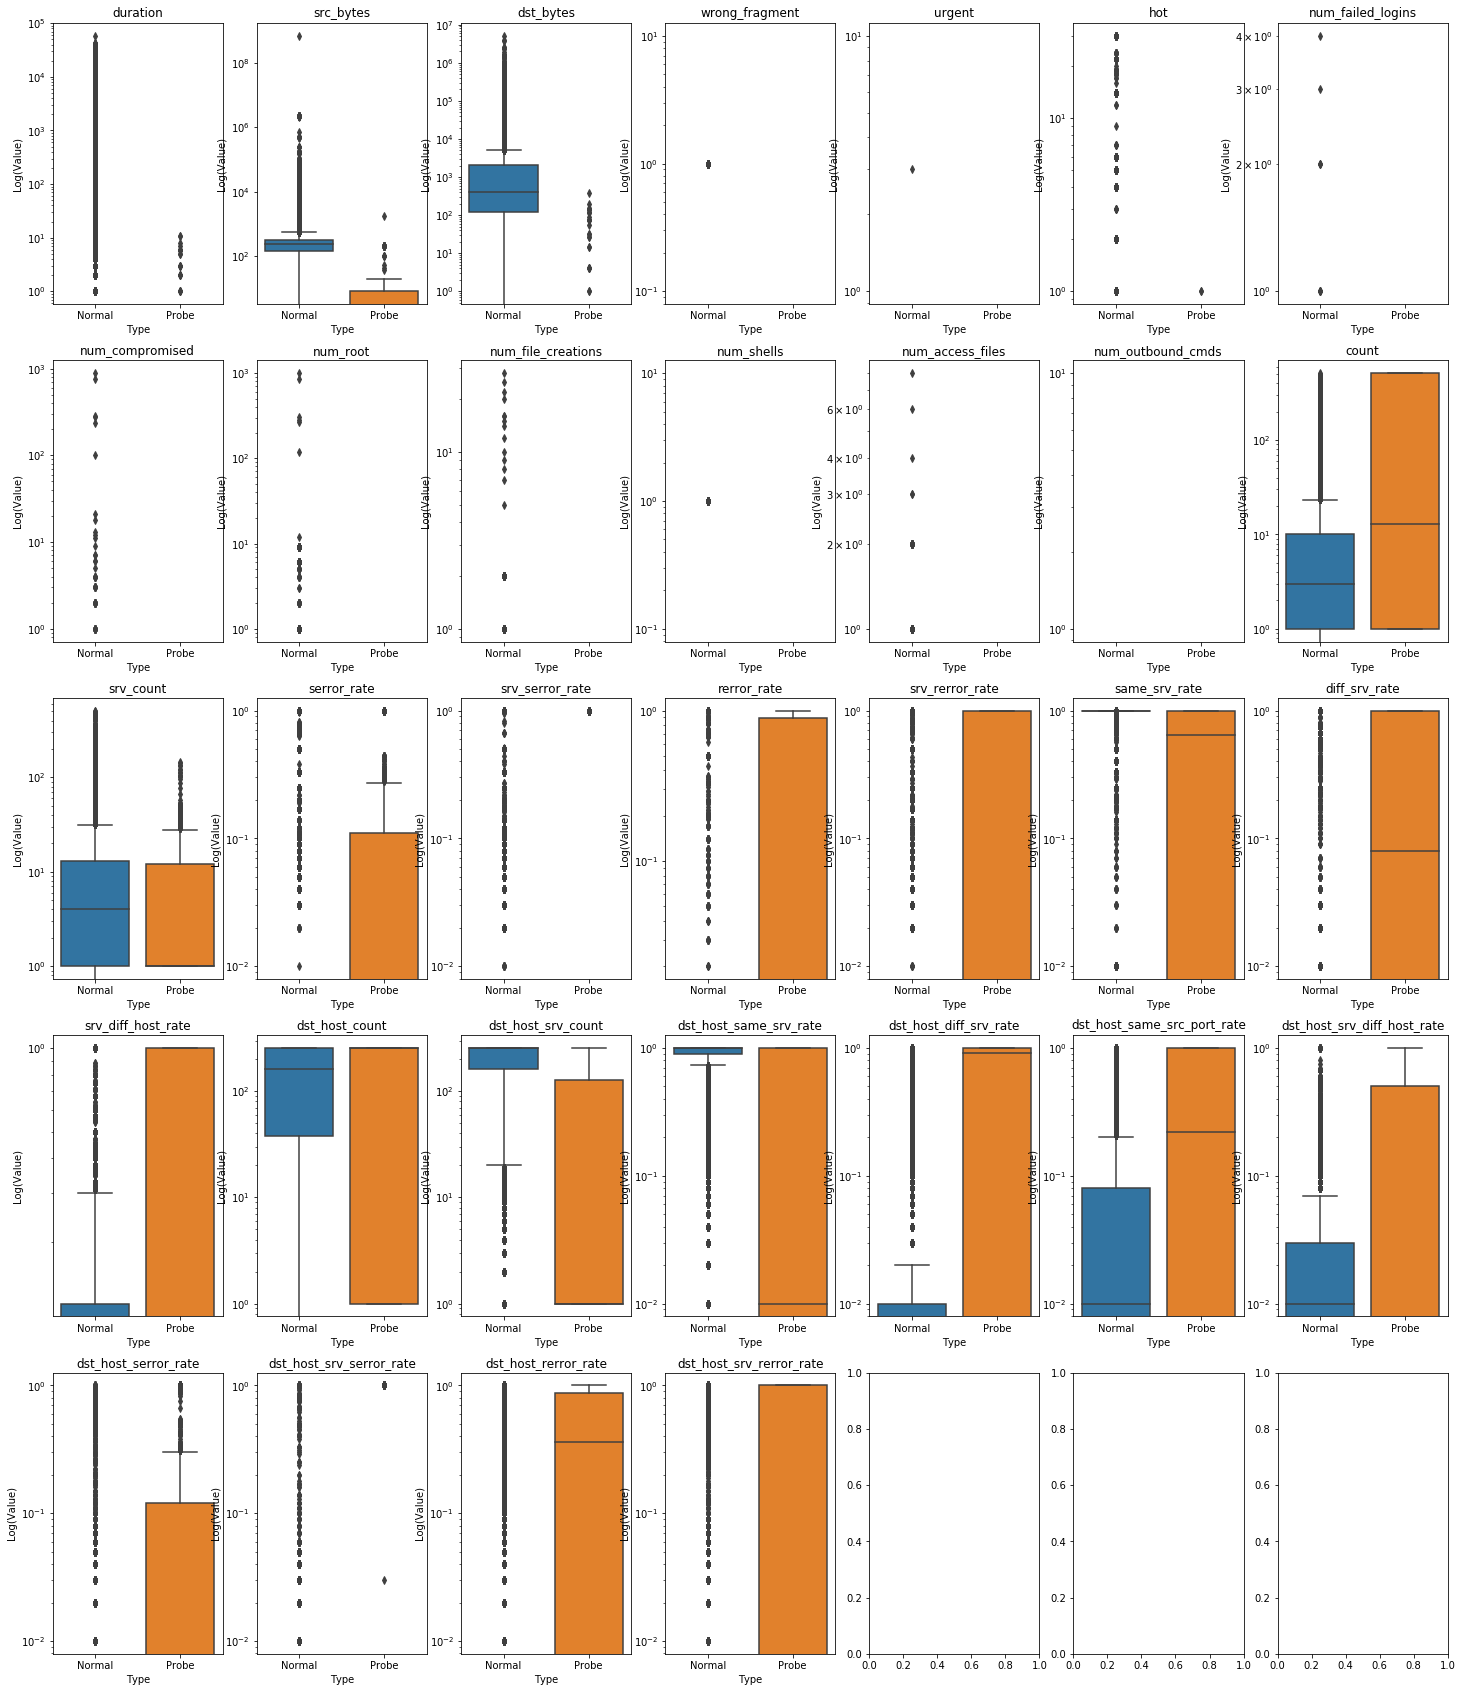

In [57]:
VisNumFeature(df_utr, method = 'boxplot', attack_type = 'Probe',scale = 'log')

In [77]:
df_columns = df.columns.tolist()#.tolist().delete('protocol_type','service','flag')
categorical_columns_index = [1,2,3,6,11,20,21,41]

numerical_columns = np.delete(df_columns, categorical_columns_index)
categorical_columns = ['protocol_type', 'service', 'flag', 'land',
                       'is_host_login', 'is_guest_login']

In [78]:
std = StandardScaler()

for col in numerical_columns:
    raw_df[col] = std.fit_transform(raw_df[[col]])

In [79]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis = 1, inplace = True)

In [80]:
encode_text_dummy(raw_df, 'protocol_type')
encode_text_dummy(raw_df, 'service')
encode_text_dummy(raw_df, 'flag')
encode_text_dummy(raw_df, 'logged_in')
encode_text_dummy(raw_df, 'is_host_login')
encode_text_dummy(raw_df, 'is_guest_login')

raw_df.dropna(inplace = True, axis =1)
raw_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,...,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,0,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,...,0,0,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,0,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,...,0,0,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,0,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,...,0,0,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,0,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,...,0,0,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,0,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,...,0,0,0,1,0,0,1,1,1,0


In [81]:
normal_mask = raw_df['outcome'] == 'normal.'
attack_mask = raw_df['outcome'] != 'normal.'

raw_df.drop(columns = 'outcome', inplace = True)

df_normal = raw_df[normal_mask]
df_attack = raw_df[attack_mask]

print("Normal Count: ", len(df_normal))
print("Attack Count:", len(df_attack))

Normal Count:  97278
Attack Count: 396743


In [73]:
x_normal = df_normal.values
x_attack = df_attack.values

x_normal_train, x_normal_test = train_test_split(x_normal, test_size = 0.25, random_state = 42)

print("Normal Train Count:", len(x_normal_train))
print("Normal Test Count:", len(x_normal_test))

NameError: name 'df_attack' is not defined

In [ ]:
model = Sequential()
model.add(Dense(25, input_dim = x_normal.shape[1], activation = 'relu'))
model.add(Dense(3, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(x_normal.shape[1]))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

In [ ]:
model.fit(x_normal_train, x_normal_train, batch_size = 50,
          validation_split = 0.25,
          verbose = 1, epochs = 30,
         callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)])

In [ ]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred, x_normal_test))
pred = model.predict(x_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred, x_normal))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred, x_attack))

print(f"Insample Normal Score (RMSE): {score1}".format(score1))
print(f"Out of Sample Normal Score (RMSE): {score2}")
print(f"Attack Underway Score (RMSE): {score3}")